# Finding the best neighbourhood in Brisbane for families with children

**About this notebook**

This notebook was made for the IBM Capstone Project: The Battle of Neighborhoods (Week 2)

## Introduction/Business Problem
**Description of the problem and a discussion of the background. (15 marks)**

Families with children often move cities or even countries.  It is often difficult to know which suburb or neighbourhood to move to within a city.  What is the crime rate in that neighbourhood?  What are the schools like?  What sort of venues are most common there?  What is the best suburb for my family?

The assumed problem is that a family wants to re-locate to Brisbane, Australia.  They want a neighbourhood with common venues suitable for children, like parks and soccer fields.  If possible, they want to be in an area where their children can go to a state (public/free) school which achieves better than average results.  They would like the lowest crime rate possible.  Which neighbhourhood should they choose?

## Data
**A description of the data and how it will be used to solve the problem. (15 marks)**

**1. Postcode data**
Data will be needed regarding all the postcodes in Brisbane, with their suburbs (neighbhourhoods) and latitude and longitude. Postcodes cover more than one suburb/neighbhourhood, so neighbhourhoods will need to be concatenated under each postcode.  The postcodes will need to be filtered to only include ones belonging to Brisbane.  Eventually, this cleaned-up dataset will be needed to place each neighbourhoods for each postcode on a map and to see location of the clusters visually.

Dataset source: https://www.matthewproctor.com/australian_postcodes

This website provides a CSV file with Australian suburbs, their postcode, and latitude/longitude.

**2. Crime data**
Data will be needed regarding crimes committed in a recent period by postcode.

Dataset source: Queensland Police Service — Online Crime Map at https://qps-ocm.s3-ap-southeast-2.amazonaws.com/index.html

The website only allows for a Excel file to be downloaded on 10 postcodes at a time for a recent 2 year period.  Therefore, each file needs to be processed, grouped, and appended to one dataframe.  As each type of crime is listed by the date and postcode, the data will need to be grouped by postcode and the number of crimes for each postcode counted.

The number of crimes ('Acts of Crime') for each postcode will need to be converted into categorical data (e.g. Moderately High) and one-hot encoded in preparation for the k-means algorithm.

**3. School data**
Data will be needed regarding the postcode a school is located in.

Dataset source: Queensland Government - Open Data Portal at https://www.data.qld.gov.au/

This datafile lists details regarding every school in Queensland. This will be filtered to include only relevant details for state schools in Brisbane.

**4. School performance data**
Data will be needed about the performance of each school in Brisbane.

Dataset source: Queensland government website QCAA provides the 2019 NAPLAN Outcomes on all Queensland Schools as a PDF file.

A dataset needs to be extracted from the PDF file. Different methods were tried to extract the data.  A Python library (Tabula) was used to directly access the PDF and convert it into tables, but for some strange reason it would lose the data on the first school at the top of every page.  Therefore, other methods were tried: the PDF was converted to an Excel file, CSV file, but these both had severe formatting problems.  Finally, the PDF was converted to a HTML file.  The HTML file was converted into rows and columns of data, but it still required a complicated process to turn it into a useful DataFrame.  For example, test results in different year groups and across different subjects need to be combined and averaged for each school so that a single test score can be used to 'rate' the performance of each school later.

This DataFrame includes the results of the 2019 standard testing.  The DataFrame is filtered for only 'localities' (i.e. Suburbs) in the Brisbane area.  Since it only uses the school name as an indentifer for each school, a join is required on this field with the school dataset (3) above to match schools and get the postcode and school type into one combined dataset.  Once this is done, the DataFrame can be filtered for only brisbane postcodes and schools that state owned.

As the average test score is numerical data, this field needs converting into categorical data (e.g. 'Top Rated' or 'Significantly Below Average') and one-hot encoded in preparation for the k-means algorithm.

**5. Foursquare venue data**
Data will be needed about the most common venues related to each Brisbane postcode/neighbhourhood.

Dataset source: Foursquare API

Data about each venue for each postcode will be grouped by postcode/neighbourhood and one-hot encoded in preparation for the k-means algorithm.

**Combining the datasets**

Datasets 2, 3, 4 and 5 (above) will need to be integrated into one dataset to perform the k-means algorithm.  Combinations of these datasets will be needed for analysis of each cluster.

#### Import dependencies

In [1]:
#!pip install bs4
#!pip install requests
#!pip install html5lib

In [3]:
# import libraries
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np # library to handle data in a vectorized manner
from bs4 import BeautifulSoup # this module helps in web scrapping
import requests  # this module helps us to download a web page
import html5lib
import re  # for splitting using regex

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import pgeocode

import requests # library to handle requests

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# for chaining/combining lists
import itertools

# for plotting
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statistics import mean

print('Libraries imported.')

Libraries imported.


# 1. Postcode data

## Clean up dataset to isolate only Brisbane postcodes

In [4]:
# read file into DataFrame
# this csv file is care of https://www.matthewproctor.com/australian_postcodes
postcodes_df = pd.read_csv('australian_postcodes.csv')
postcodes_df.head()

,id,postcode,locality,state,long,lat,dc,type,status,sa3,sa3name,sa4,sa4name,region,Lat_precise,Long_precise,SA1_MAINCODE_2011,SA1_MAINCODE_2016,SA2_MAINCODE_2016,SA2_NAME_2016,SA3_CODE_2016,SA3_NAME_2016,SA4_CODE_2016,SA4_NAME_2016,RA_2011,RA_2016,MMM_2015,MMM_2019
0,230,200,ANU,ACT,149.119000,-35.277700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R1,-35.277700,149.119000,8.010510e+10,8.010510e+10,801051049.0,Acton,80105.0,North Canberra,801.0,Australian Capital Territory,1.0,1.0,1.0,1.0
1,21820,200,Australian National University,ACT,149.118900,-35.277700,NaN,NaN,Added 19-Jan-2020,NaN,NaN,NaN,NaN,R1,-35.277700,149.118527,8.010510e+10,8.010510e+10,801051049.0,Acton,80105.0,North Canberra,801.0,Australian Capital Territory,1.0,1.0,1.0,1.0
2,232,800,DARWIN,NT,130.836680,-12.458684,NaN,NaN,Updated 6-Feb-2020,70101.0,Darwin City,701.0,Darwin,R1,-12.393279,130.776661,7.010110e+10,7.010110e+10,701011002.0,Darwin City,70101.0,Darwin City,701.0,Darwin,3.0,3.0,2.0,2.0
3,233,801,DARWIN,NT,130.836680,-12.458684,NaN,NaN,Updated 25-Mar-2020 SA3,70101.0,Darwin City,701.0,Darwin,R1,-12.463440,130.845642,7.010110e+10,7.010110e+10,701011002.0,Darwin City,70101.0,Darwin City,701.0,Darwin,3.0,3.0,2.0,2.0
4,234,804,PARAP,NT,130.873315,-12.428017,NaN,NaN,Updated 25-Mar-2020 SA3,70102.0,Darwin Suburbs,701.0,Darwin,R1,-12.432480,130.846254,7.010110e+10,7.010110e+10,701011007.0,Parap,70101.0,Darwin City,701.0,Darwin,3.0,3.0,2.0,2.0


**Include only relevant columns...**

In [5]:
postcodes_df = postcodes_df[['postcode', 'locality', 'sa4name', 'long', 'lat']]
postcodes_df.head()

,postcode,locality,sa4name,long,lat
0,200,ANU,NaN,149.119000,-35.277700
1,200,Australian National University,NaN,149.118900,-35.277700
2,800,DARWIN,Darwin,130.836680,-12.458684
3,801,DARWIN,Darwin,130.836680,-12.458684
4,804,PARAP,Darwin,130.873315,-12.428017


In [6]:
# give columns more appropriate names
postcodes_df.rename(columns = {'postcode': 'Postcode', 'locality': 'Suburb', 'sa4name': 'Area', 'lat': 'Latitude', 'long': 'Longitude'}, inplace = True)

In [7]:
# check how many postcodes are missing values
postcodes_df.isna().sum()

Postcode       0
Suburb         0
Area         249
Longitude      0
Latitude       0
dtype: int64

In [8]:
# drop rows if no sa4name can be looked up for that postcode
postcodes_df = postcodes_df.dropna(subset = ["Area"], inplace=False).reset_index(drop=True)

In [9]:
# create new DataFrame for just Brisbane postcodes
brisbane_postcodes = postcodes_df[postcodes_df['Area'].str.contains('Brisbane',case=False)]
brisbane_postcodes.head()

,Postcode,Suburb,Area,Longitude,Latitude
9491,4000,BRISBANE,Brisbane Inner City,153.022126,-27.468391
9492,4000,BRISBANE ADELAIDE STREET,Brisbane Inner City,153.022126,-27.468391
9493,4000,BRISBANE CITY,Brisbane Inner City,153.025123,-27.469771
9494,4000,BRISBANE CITY DC,Brisbane Inner City,153.022126,-27.468391
9495,4000,BRISBANE GPO,Brisbane Inner City,153.022126,-27.468391


**Find out how many suburbs...**

In [10]:
rows, cols = brisbane_postcodes.shape
print('Brisbane has', str(rows), 'suburbs')

Brisbane has 294 suburbs


**Find out how many postcodes...**

In [11]:
unique_postcodes = brisbane_postcodes['Postcode'].nunique()
print('Brisbane has', str(unique_postcodes), 'postcodes')

Brisbane has 85 postcodes


**We want 1 postcode per row, so need to group suburbs under postcodes...**

In [12]:
grouped_A = brisbane_postcodes.groupby(['Postcode', 'Area']).mean()
grouped_A = grouped_A.reset_index()
grouped_A.rename(columns = {'Longitude_mean': 'Longitude', 'Latitude_mean': 'Latitude'}, inplace = True)
grouped_A.head()

,Postcode,Area,Longitude,Latitude
0,4000,Brisbane Inner City,153.022459,-27.468544
1,4001,Brisbane Inner City,152.823141,-27.603479
2,4004,Brisbane Inner City,149.316593,-24.045265
3,4005,Brisbane Inner City,153.046752,-27.463097
4,4006,Brisbane Inner City,153.175242,-27.366180


<details><summary>Click here for alternative way (longer way) to make same DataFrame as grouped_A</summary>

```python
    
grouped_multiple = brisbane_postcodes.groupby(['Postcode', 'Area']).agg({'Longitude': ['mean'], 'Latitude': ['mean']})
grouped_multiple.columns = ['Longitude_mean', 'Latitude_mean']
grouped_multiple = grouped_multiple.reset_index()
grouped_multiple

```

</details>

In [13]:
# concatenate suburbs grouped by postcode
grouped_B = brisbane_postcodes.groupby(['Postcode', 'Area'])['Suburb'].apply(', '.join).reset_index()
grouped_B.head()

,Postcode,Area,Suburb
0,4000,Brisbane Inner City,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C..."
1,4001,Brisbane Inner City,BRISBANE
2,4004,Brisbane Inner City,SPRING HILL
3,4005,Brisbane Inner City,"NEW FARM, TENERIFFE"
4,4006,Brisbane Inner City,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION..."


**Create new Brisbane postcodes DataFrame (with postcode as index)**

In [14]:
grouped_A.head()

,Postcode,Area,Longitude,Latitude
0,4000,Brisbane Inner City,153.022459,-27.468544
1,4001,Brisbane Inner City,152.823141,-27.603479
2,4004,Brisbane Inner City,149.316593,-24.045265
3,4005,Brisbane Inner City,153.046752,-27.463097
4,4006,Brisbane Inner City,153.175242,-27.366180


In [15]:
# add grouped_B comma-delimited suburbs to grouped_A
grouped_A.insert(2, 'Suburb', grouped_B['Suburb'])
#grouped_A.drop(columns='index')

In [16]:
# rename 'Suburb' field as 'Neighbhourhood'
grouped_A.rename(columns = {'Suburb': 'Neighbourhood'}, inplace = True)

In [17]:
grouped_A.drop(columns='Area', inplace = True)

In [18]:
# call the new DataFrame postcodes
postcodes = grouped_A

In [19]:
# view postcodes that are redundant (ie. they have the same lat/long)
postcodes.tail(12)

,Postcode,Neighbourhood,Longitude,Latitude
73,4184,"COOCHIEMUDLO ISLAND, KARRAGARRA ISLAND, LAMB I...",153.384655,-27.676499
74,4222,GRIFFITH UNIVERSITY,153.052226,-27.550643
75,9000,BRISBANE,152.823141,-27.603479
76,9001,BRISBANE,152.823141,-27.603479
77,9002,BRISBANE,152.823141,-27.603479
78,9005,BRISBANE,152.823141,-27.603479
79,9007,BRISBANE,152.823141,-27.603479
80,9009,BRISBANE,152.823141,-27.603479
81,9010,BRISBANE,152.823141,-27.603479
82,9013,BRISBANE,152.823141,-27.603479


**Problem: Postcodes from 9000 to 9015 all have same lat & long and are redundant as postcode 4000 also has the same lat & long, also there is no crime data on these postcodes supporting the idea they are redundant.**

**Fix: Remove redundant postcodes from 9000 to 9015...**

In [20]:
# work out the correct condition to drop these rows
#rows_to_drop = postcodes[(postcodes['Postcode'] >= 9000) & (postcodes['Postcode'] <= 9015)]
rows_to_drop1 = postcodes[(postcodes['Postcode'] > 9000)]
rows_to_drop2 = postcodes[(postcodes['Postcode'] == 4001)]
rows_to_drop3 = postcodes[(postcodes['Postcode'] == 4004)]          
print(rows_to_drop1)
print(rows_to_drop2)
print(rows_to_drop3)

    Postcode Neighbourhood   Longitude   Latitude
76      9001      BRISBANE  152.823141 -27.603479
77      9002      BRISBANE  152.823141 -27.603479
78      9005      BRISBANE  152.823141 -27.603479
79      9007      BRISBANE  152.823141 -27.603479
80      9009      BRISBANE  152.823141 -27.603479
81      9010      BRISBANE  152.823141 -27.603479
82      9013      BRISBANE  152.823141 -27.603479
83      9015      BRISBANE  152.823141 -27.603479
84      9464  NORTHGATE MC  153.074982 -27.397055
   Postcode Neighbourhood   Longitude   Latitude
1      4001      BRISBANE  152.823141 -27.603479
   Postcode Neighbourhood   Longitude   Latitude
2      4004   SPRING HILL  149.316593 -24.045265


In [21]:
# get names of indexes for which
# column Postcode has value >9015
index_names = rows_to_drop1.index
  
# drop these row indexes
# from dataFrame
postcodes.drop(index_names, inplace = True)

# column Postcode has value 4001
index_names = rows_to_drop2.index

# drop these row indexes
# from dataFrame
postcodes.drop(index_names, inplace = True)

# column Postcode has value 4004
index_names = rows_to_drop3.index

# drop these row indexes
# from dataFrame
postcodes.drop(index_names, inplace = True)

print('The rows above were dropped!')

The rows above were dropped!


In [22]:
# reset the index because rows have been removed
postcodes = postcodes.reset_index()

# drop old index column
postcodes.drop(columns='index', inplace = True)

postcodes.head()

,Postcode,Neighbourhood,Longitude,Latitude
0,4000,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",153.022459,-27.468544
1,4005,"NEW FARM, TENERIFFE",153.046752,-27.463097
2,4006,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION...",153.175242,-27.366180
3,4007,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",153.061914,-27.436088
4,4008,"BRISBANE AIRPORT, BULWER ISLAND, MEEANDAH, MYR...",153.136496,-27.397546


In [23]:
rows, cols = postcodes.shape
print('Not including redundant postcodes, Brisbane has', str(rows), 'postcodes')

Not including redundant postcodes, Brisbane has 74 postcodes


In [24]:
# create a simpler DataFrame for use later
just_postcodes_neighbhourhoods = postcodes[['Postcode','Neighbourhood']]
just_postcodes_neighbhourhoods.head()

,Postcode,Neighbourhood
0,4000,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C..."
1,4005,"NEW FARM, TENERIFFE"
2,4006,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION..."
3,4007,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA..."
4,4008,"BRISBANE AIRPORT, BULWER ISLAND, MEEANDAH, MYR..."


# 2. Crime data

## Extract and group crime dataset

These crime datasets are care of the Queensland Police Service — Online Crime Map at https://qps-ocm.s3-ap-southeast-2.amazonaws.com/index.html

The website only allows for a dataset to be downloaded on 10 postcodes at a time.  Therefore, each file needs to be processed, grouped, and appended to one dataframe as done below.

In [25]:
# define function to do the same steps for every crime file (each crime file has statistics for 10 brisbane postcodes at a time)
def getGroupedByCrimeDf(filename):
    print('Processing file:', filename, '...')
    raw_crime_df = pd.read_excel (filename)
    
    # group the data by postcode   
    grouped_crime_subset = raw_crime_df.groupby(['Suburb']).size()
    grouped_crime_subset = grouped_crime_subset.reset_index()
    grouped_crime_subset.rename(columns = {'Suburb': 'Postcode', 0: 'Acts of Crime'}, inplace = True)
    print('  Done!')
    return(grouped_crime_subset)

In [26]:
all_data = pd.DataFrame()
# files to process
filename_list = ['OCM - 4000.xlsx','OCM - 4014.xlsx','OCM - 4051.xlsx','OCM - 4073.xlsx','OCM - 4111.xlsx','OCM - 4153.xlsx','OCM - 4164.xlsx','OCM - 4183.xlsx']

# loop thorugh each crime file
for i in range(0, len(filename_list)):
    crime_subset = getGroupedByCrimeDf(filename_list[i])
    all_data = all_data.append(crime_subset,ignore_index=True)
    
crime_df = all_data
crime_df.head(20)


Processing file: OCM - 4000.xlsx ...
  Done!
Processing file: OCM - 4014.xlsx ...
  Done!
Processing file: OCM - 4051.xlsx ...
  Done!
Processing file: OCM - 4073.xlsx ...
  Done!
Processing file: OCM - 4111.xlsx ...
  Done!
Processing file: OCM - 4153.xlsx ...
  Done!
Processing file: OCM - 4164.xlsx ...
  Done!
Processing file: OCM - 4183.xlsx ...
  Done!


,Postcode,Acts of Crime
0,4000,21928
1,4005,2396
2,4006,15145
3,4007,2359
4,4008,1089
5,4009,331
6,4010,777
7,4011,1956
8,4012,3653
9,4013,1061


In [27]:
# rename Suburb column as Postcode
crime_df.rename(columns = {'Suburb': 'Postcode'}, inplace = True)
crime_df.head()

,Postcode,Acts of Crime
0,4000,21928
1,4005,2396
2,4006,15145
3,4007,2359
4,4008,1089


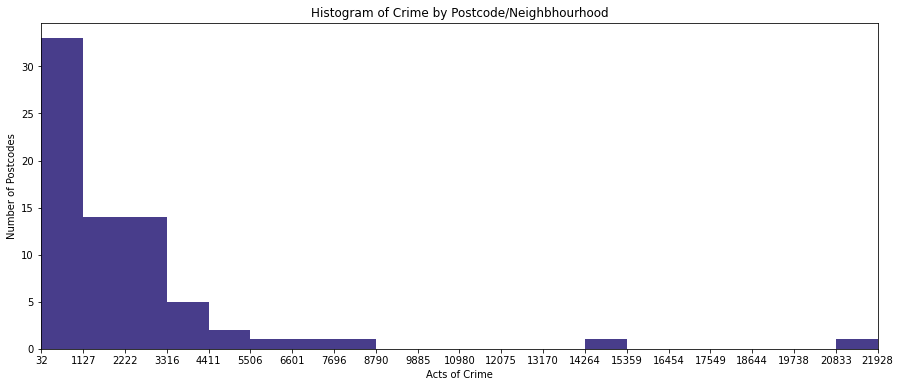

In [28]:
num_bins = 20
count, bin_edges = np.histogram(crime_df['Acts of Crime'], num_bins)
xmin = bin_edges[0] - 10   #  first bin value is 31.0, adding buffer of 10 for aesthetic purposes 
xmax = bin_edges[-1] + 10  #  last bin value is 308.0, adding buffer of 10 for aesthetic purposes

# stacked Histogram
crime_df['Acts of Crime'].plot(kind='hist',
          figsize=(15, 6), 
          bins=num_bins,
          xticks=bin_edges,
          color=['darkslateblue', 'coral', 'mediumseagreen'],
          stacked=True,
          xlim=(xmin, xmax)
         )

plt.title('Histogram of Crime by Postcode/Neighbhourhood')
plt.ylabel('Number of Postcodes')
plt.xlabel('Acts of Crime') 

plt.show()

In [29]:
print(count) # frequency count#
print(bin_edges) # bin ranges, default = 10 bins

[33 14 14  5  2  1  1  1  0  0  0  0  0  1  0  0  0  0  0  1]
[   32.   1126.8  2221.6  3316.4  4411.2  5506.   6600.8  7695.6  8790.4
  9885.2 10980.  12074.8 13169.6 14264.4 15359.2 16454.  17548.8 18643.6
 19738.4 20833.2 21928. ]


In [30]:
#add a new column category next to the Acts of Crime column. 
category = pd.cut(crime_df['Acts of Crime'],bins=[0,1126.8,2221.6,3316.4,4411.2,5506,6600.8,7695.6,8790.4,15359.2,22000], labels=['Extremely Low','Very Very Low','Very Low','Moderately Low','Fairly Low','Fairly High','Moderately High','Very High','Very Very High','Extremely High'])
crime_df.insert(1,'Crime Group',category)

In [31]:
crime_df

,Postcode,Crime Group,Acts of Crime
0,4000,Extremely High,21928
1,4005,Very Low,2396
2,4006,Very Very High,15145
3,4007,Very Low,2359
4,4008,Extremely Low,1089
5,4009,Extremely Low,331
6,4010,Extremely Low,777
7,4011,Very Very Low,1956
8,4012,Moderately Low,3653
9,4013,Extremely Low,1061


In [32]:
crimes_condensed = crime_df[['Postcode','Crime Group']]
crimes_condensed.head()

,Postcode,Crime Group
0,4000,Extremely High
1,4005,Very Low
2,4006,Very Very High
3,4007,Very Low
4,4008,Extremely Low


In [33]:
# merge DataFrames to get 'Neighbhourhood' column added
crimes_with_neighbourhood = crimes_condensed.join(just_postcodes_neighbhourhoods.set_index('Postcode'), how='right', on='Postcode')

# move neighbourhood column to the first column
fixed_columns = [crimes_with_neighbourhood.columns[-1]] + list(crimes_with_neighbourhood.columns[:-1])
crimes_with_neighbourhood = crimes_with_neighbourhood[fixed_columns]

# drop 'Postcode' column as not needed
crimes_with_neighbourhood = crimes_with_neighbourhood.drop('Postcode', 1)

# reset index
crimes_with_neighbourhood = crimes_with_neighbourhood.reset_index()

# drop old index column
crimes_with_neighbourhood = crimes_with_neighbourhood.drop('index', 1)

crimes_with_neighbourhood.head()

,Neighbourhood,Crime Group
0,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",Extremely High
1,"NEW FARM, TENERIFFE",Very Low
2,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION...",Very Very High
3,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",Very Low
4,"BRISBANE AIRPORT, BULWER ISLAND, MEEANDAH, MYR...",Extremely Low


In [34]:
rows, cols = crimes_with_neighbourhood.shape
print('There is crime data on', str(rows), 'postcodes')

There is crime data on 74 postcodes


In [35]:
# one hot encoding
crime_grouped = pd.get_dummies(crimes_with_neighbourhood, columns=["Crime Group"], prefix=["Crime"])
crime_grouped.head()

,Neighbourhood,Crime_Extremely Low,Crime_Very Very Low,Crime_Very Low,Crime_Moderately Low,Crime_Fairly Low,Crime_Fairly High,Crime_Moderately High,Crime_Very High,Crime_Very Very High,Crime_Extremely High
0,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",0,0,0,0,0,0,0,0,0,1
1,"NEW FARM, TENERIFFE",0,0,1,0,0,0,0,0,0,0
2,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION...",0,0,0,0,0,0,0,0,1,0
3,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",0,0,1,0,0,0,0,0,0,0
4,"BRISBANE AIRPORT, BULWER ISLAND, MEEANDAH, MYR...",1,0,0,0,0,0,0,0,0,0


# 3. School data

**Get school data i.e. the school names with postcodes so we can eventually filter for just performance data of schools with Brisbane postcodes**

In [36]:
# read file into DataFrame
# this csv file is provided by Queensland gov website
school_df = pd.read_csv('SchoolDetails_May_2020.csv')
school_df.head()

,Centre Code,Centre Name,Centre Type,Centre Status,Host Centre Code,Host Centre Name,Official Low Year Level,Official High Year Level,Officer In Charge Title,School Band,Show Holiday Date,Internet Site,Phone Number,Restrict Contact Outside Teaching Hours,Fax Number,Actual Address Line 1,Actual Address Line 2,Actual Address Line 3,Actual Address Post Code,Postal Address Line 1,Postal Address Line 2,Postal Address Line 3,Postal Address Post Code,Education Geographic Region,Federal Electorate,State Electorate,Local Government Area,Statistical Area Level2,Statistical Area Level2 Code,Remoteness Area,Enrolment Effective Date,All Student Count,Campus All Student Count,ABN,Sector,Non-State Sector,Longitude,Latitude
0,5817,A B Paterson College (Arundel),Non-State School,Open,NaN,NaN,Prep Year,Year 12,Principal,NaN,NaN,www.abpat.qld.edu.au,(07) 5594 7947,N,(07) 5594 7650,NaN,10 A B Paterson Drive,Arundel,4214,10 A B Paterson Drive,Arundel,NaN,4214,South East,Fadden,Bonney,Gold Coast (C),Arundel,309031235,Major Cities of Australia,NaN,NaN,NaN,NaN,Non-State,Independent,153.360364,-27.927672
1,0591,Abercorn State School,State School,Open,NaN,NaN,Prep Year,Year 6,Principal,5.0,10 August 2020,www.abercornss.eq.edu.au,(07) 4167 5190,Y,(07) 4167 5135,NaN,957 Wuruma Dam Road,Abercorn,4627,957 Wuruma Dam Road,Abercorn,NaN,4627,Central Queensland,Flynn,Callide,North Burnett (R),Monto - Eidsvold,319021508,Outer Regional Australia,2019 July,18.0,NaN,2.210125e+10,State,NaN,151.127031,-25.135955
2,1275,Abergowrie State School,State School,Open,NaN,NaN,Prep Year,Year 6,Principal,5.0,03 July 2020,www.abergowriess.eq.edu.au,(07) 4777 4672,N,(07) 4777 4686,NaN,5 Venables Road,Abergowrie,4850,5 Venables Road,Abergowrie,NaN,4850,North Queensland,Kennedy,Hinchinbrook,Hinchinbrook (S),Ingham Region,318011465,Remote Australia,2019 July,4.0,NaN,8.724407e+10,State,NaN,145.883510,-18.474697
3,5588,Aboriginal & Islander Independent Community Sc...,Non-State School,Open,NaN,NaN,Prep Year,Year 12,Principal,NaN,NaN,www.murrischool.com,(07) 3255 6133,NaN,(07) 3255 6562,NaN,1277 Beaudesert Road,Acacia Ridge,4110,PO Box 256,Acacia Ridge,NaN,4110,Metropolitan,Moreton,Algester,Brisbane (C),Rocklea - Acacia Ridge,303051076,Major Cities of Australia,NaN,NaN,NaN,NaN,Non-State,Independent,153.025757,-27.581562
4,0025,Acacia Ridge State School,State School,Open,NaN,NaN,Early Childhood,Year 6,Principal,8.0,12 August 2020,www.acaciaridgess.eq.edu.au,(07) 3717 4111,N,(07) 3717 4100,NaN,Nyngam Street,Acacia Ridge,4110,Nyngam Street,Acacia Ridge,NaN,4110,Metropolitan,Moreton,Algester,Brisbane (C),Rocklea - Acacia Ridge,303051076,Major Cities of Australia,2019 July,379.0,NaN,9.928509e+10,State,NaN,153.016074,-27.579554


## Clean up school data

In [37]:
# get only the required columns
school_df = school_df[["Centre Name", "Postal Address Line 2", "Postal Address Post Code", "Centre Type", "Latitude", "Longitude"]]
school_df.head()

,Centre Name,Postal Address Line 2,Postal Address Post Code,Centre Type,Latitude,Longitude
0,A B Paterson College (Arundel),Arundel,4214,Non-State School,-27.927672,153.360364
1,Abercorn State School,Abercorn,4627,State School,-25.135955,151.127031
2,Abergowrie State School,Abergowrie,4850,State School,-18.474697,145.883510
3,Aboriginal & Islander Independent Community Sc...,Acacia Ridge,4110,Non-State School,-27.581562,153.025757
4,Acacia Ridge State School,Acacia Ridge,4110,State School,-27.579554,153.016074


In [38]:
# rename columns
school_df.rename(columns = {'Centre Name': 'School', 'Centre Type': 'Type', 'Postal Address Line 2': 'Locality', 'Postal Address Post Code': 'Postcode', 'Latitude': 'School Latitude', 'Longitude': 'School Longitude'}, inplace = True)
school_df.head()

,School,Locality,Postcode,Type,School Latitude,School Longitude
0,A B Paterson College (Arundel),Arundel,4214,Non-State School,-27.927672,153.360364
1,Abercorn State School,Abercorn,4627,State School,-25.135955,151.127031
2,Abergowrie State School,Abergowrie,4850,State School,-18.474697,145.883510
3,Aboriginal & Islander Independent Community Sc...,Acacia Ridge,4110,Non-State School,-27.581562,153.025757
4,Acacia Ridge State School,Acacia Ridge,4110,State School,-27.579554,153.016074


# 4. School Performance Data

## Extract school performance data

**First, school performance data is extracted from the HTML file and turned into a useful DataFrame**

In [39]:
# this is the webpage url to extract the data from
url = 'file:///C:/Users/test/OneDrive/data%20science/qcaa_stats_naplan_19_outcomes.html'

In [40]:
# there is no need to make the request if the html file is local...

# get the html data from the page
#html_data = requests.get(url).text 

# instead, get the html data from the file
with open('qcaa_stats_naplan_19_outcomes.html', 'r') as f:
    html_data = f.read()

In [41]:
# convert all the html to soup
soup = BeautifulSoup(html_data,"html5lib")

In [42]:
# check html header
soup.head()

[<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>,
 <title>NAPLAN 2019 Outcomes: All Queensland Schools</title>,
 <meta content="Queensland Curriculum and Assessment Authority" name="author"/>,
 <style type="text/css"> * {margin:0; padding:0; text-indent:0; }
  h1 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: bold; text-decoration: none; font-size: 27.5pt; }
  .s1 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 16pt; }
  .s2 { color: black; font-family:Arial, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 12pt; }
  a { color: #A7A9AC; font-family:Calibri, sans-serif; font-style: normal; font-weight: normal; text-decoration: none; font-size: 12.5pt; }
  .s3 { color: #A7A9AC; font-family:Calibri, sans-serif; font-style: italic; font-weight: normal; text-decoration: none; font-size: 17pt; }
  h2 { color: black; font-family:

In [43]:
#find all html tables in the web page
tables = soup.find_all('table') # in html table is represented by the tag <table>

In [44]:
# we can see how many tables were found by checking the length of the tables list
print('There are', str(len(tables)), 'tables in this html file!')

There are 151 tables in this html file!


**Define functions to help extract data from html file**

In [45]:
# if you compile the regex string first, it's even faster
RE_express = re.compile('%|\d')
def check_for_only_num_space_percent(string):
    return RE_express.search(string)

In [46]:
# remove non-result string (i.e. one that does not have numbers or %), and make it blank
def remove_non_result_string(check_string):
    if (check_for_only_num_space_percent(check_string)):    
        return check_string
    else:
        return ''  # return a blank string

In [47]:
# if you compile the regex string first, it's even faster
RE_express = re.compile('\d')
def return_string_if_only_numbers(string):
    if (RE_express.search(string)):
        return string
    else:
        return ''

In [48]:
# extracting attendance
# e.g. 109 104 139 137     2 2 â€“ â€“    â€“ 78 239 239
def split_string_list(temp_string):
    split_string_list = temp_string.split()
    for i in range(0, len(split_string_list)):
        split_string_list[i] = return_string_if_only_numbers(split_string_list[i])
    # remove empty items from the list
    split_string_list = list(filter(None, split_string_list))
    return split_string_list

In [49]:
# splitting avg score & percent studs above NMS
# 390 372 363 384 37188% 88% 82% 82% 88%    390 372 363 384 371100% 99% 100% 100% 99%
def break_joined_score_percent_fields(temp_string):
    # find position of % sign
    temp_string = temp_string.strip()
    percent_position = temp_string.find('%')
    # get the 3 characters before the % sign
    # string[ start_index_pos: end_index_pos: step_size]
    first_percent = temp_string[percent_position-3:percent_position:1]
    if (first_percent == '100'):  
        split_point = percent_position-3
    else:
        # check if first_percent must only be 2 digits or 1 digits, not 3
        # try split point where first_percent is 2 digits
        split_point = percent_position-2
    left_string, right_string = temp_string[:split_point], temp_string[split_point:]
    return left_string, right_string
    # print(left_string, '--', right_string)

In [50]:
# remove non-result string (i.e. one that is not just numbers or has a %), and make it blank
# e.g. '502âˆ§'
RE_express_has_digits = re.compile('\d+')
RE_express_has_percent = re.compile('%+')
def clean_number_or_percent_list(string_list):
    for j in range(len(string_list)):
        check_string = string_list[j]
        # if it has a numbers AND a percent sign - return the extracted number with a % sign added
        # if it has numbers but no % sign - return the extracted number
        # if it has no numbers - return a blank string
        if (RE_express_has_digits.search(check_string) and (RE_express_has_percent.search(check_string))):  # has digits AND a percent
            # print('it has digits')
            string_list[j] = RE_express_has_digits.findall(check_string)[0]+'%'
        elif (RE_express_has_digits.search(check_string)):  # has digits
            string_list[j] = RE_express_has_digits.findall(check_string)[0]
        else:  # has no digits
            string_list[j] = ''
            
    return string_list

In [51]:
# remove % signs from list of numbers with % signs
# e.g. 88% 88% 82% 82% 88%     or     100% 99% 100% 100% 99%
def remove_percent_sign_from_list(string_list):
    # replace % sign with all list items
    for j in range(len(string_list)):
        string_list[j] = string_list[j].replace('%','')
    return string_list

In [52]:
# find mean of string list
def find_mean_of_string_list(string_list):
    if (len(string_list) == 0):
        return 0
    else:
        # remove empty items from the list (in case)
        string_list = list(filter(None, string_list))

        # convert all list items to int
        for j in range(len(string_list)):
            string_list[j] = int(string_list[j])

        # return the mean of all list items
        return (round(mean(string_list), 2))

In [53]:
def find_sum_of_string_list(string_list):
    if (len(string_list) == 0):
        return 0
    else:
        # remove empty items from the list (in case)
        string_list = list(filter(None, string_list))

        # convert all list items to int
        for j in range(len(string_list)):
            string_list[j] = int(string_list[j])

        # return the mean of all list items
        return (sum(string_list))

**Run code to put html tables into useable DataFrame...**

4 types of rows:
 1. starts with a school name and it has a value for Locality - get SchoolName, Locality, and Attend numbers - save them to variables
 2. starts with 'Average score of the schoolPercentage (%) of students at or above NMS'  - both are combined in this row
     a. extract & save Scores (3d x 5 with spaces in between)
     b. extract & save the percentages
 3. starts with 'Average score of the school' a. extract & save Scores (3d x 5 with spaces in between)
 4. starts with 'Percentage (%) of students at or above NMS' b. extract & save the percentages

In [54]:
school_table_data = pd.DataFrame(columns=["School", "Locality", "Attend", "Score", "Percent"])

for table_index in range(0, len(tables)):
    # initialise variables
    cell_value = ''
    cells = []
    row_num = 0
    
    school_data_ready = False
    score_data_ready = False
    percent_data_ready = False
    
    for row in tables[table_index].tbody.find_all("tr"):
        col = row.find_all("td")
               
        #print(str(len(col)))
        if (col != []):
            
            # don't get row 0 and row 1 as they are just headers and have a different number of columns
            if (row_num > 1):
                
                for i in range(0, len(col)):

                    cell_value = col[i]
                    cell_value = ("Row",str(row_num),"Col",str(i)," cell_value:",cell_value)
                    cells.append(cell_value)

                if (len(col) == 7):
                    # check this is a school row
                    if (len(col[1].text.strip()) != 0): # if locality is not blank, this row is a school row, not result row
                        #print('school_data_ready')
                        school_data_ready = True
                        
                        # get school name
                        school_name = col[0].text.strip()
                        school_name = school_name.replace('â€™', '\'')
                        #print(school_name)
                        
                        # get locality
                        school_locality = col[1].text.strip()
                        
                        # get total attendence
                        school_attend = find_sum_of_string_list(split_string_list(col[2].text.strip())) 
                        
                    elif (col[0].text.strip() == 'Average score of the schoolPercentage (%) of students at or above NMS'):
                        #print('score_data_ready AND percent_data_ready')
                        score_data_ready = True
                        percent_data_ready = True
                        
                        # get all the results                  
                        school_result_yr3 = remove_non_result_string(col[3].text.strip())
                        school_result_yr5 = remove_non_result_string(col[4].text.strip())
                        school_result_yr7 = remove_non_result_string(col[5].text.strip())
                        school_result_yr9 = remove_non_result_string(col[6].text.strip())
                        
                        #print('Yr3:'+school_result_yr3)
                        #print('Yr5:'+school_result_yr5)
                        #print('Yr7:'+school_result_yr7)
                        #print('Yr9:'+school_result_yr9)
                        
                        # break up the combined score & % field values e.g. '390 372 363 384 371100% 99% 100% 100% 99%'
                        # yr3 result
                        left_string, right_string = break_joined_score_percent_fields(school_result_yr3)
                        yr3_score_list = clean_number_or_percent_list(split_string_list(left_string))
                        yr3_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(right_string)))
                        # yr5 result
                        left_string, right_string = break_joined_score_percent_fields(school_result_yr5)
                        yr5_score_list = clean_number_or_percent_list(split_string_list(left_string))
                        yr5_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(right_string)))
                        # yr7 result
                        left_string, right_string = break_joined_score_percent_fields(school_result_yr7)
                        yr7_score_list = clean_number_or_percent_list(split_string_list(left_string))
                        yr7_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(right_string)))
                        # yr9 result
                        left_string, right_string = break_joined_score_percent_fields(school_result_yr9)
                        yr9_score_list = clean_number_or_percent_list(split_string_list(left_string))
                        yr9_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(right_string)))
                        
                        # join the yr results lists together
                        # 1. the score lists
                        school_score_list = list(itertools.chain(yr3_score_list, yr5_score_list, yr7_score_list, yr9_score_list))
                        #print(school_score_list)
                        # 2. the % lists
                        school_percent_list = list(itertools.chain(yr3_percent_list, yr5_percent_list, yr7_percent_list, yr9_percent_list))
                        #print(school_percent_list)
                        
                        # find the mean value of the results lists
                        # 1. the score lists
                        school_mean_score = find_mean_of_string_list(clean_number_or_percent_list(school_score_list))
                        # 2. the % lists
                        school_mean_percent = find_mean_of_string_list(clean_number_or_percent_list(school_percent_list))
                        
                    elif (col[0].text.strip() == 'Average score of the school'):
                        #print('score_data_ready')
                        score_data_ready = True
                        
                        # get all the scores  
                        school_result_yr3 = remove_non_result_string(col[3].text.strip())
                        school_result_yr5 = remove_non_result_string(col[4].text.strip())
                        school_result_yr7 = remove_non_result_string(col[5].text.strip())
                        school_result_yr9 = remove_non_result_string(col[6].text.strip())
                        
                        yr3_score_list = split_string_list(school_result_yr3)
                        yr5_score_list = split_string_list(school_result_yr5)
                        yr7_score_list = split_string_list(school_result_yr7)
                        yr9_score_list = split_string_list(school_result_yr9)
                        
                        # join the yr scores lists together
                        school_score_list = list(itertools.chain(yr3_score_list, yr5_score_list, yr7_score_list, yr9_score_list))
                        # find the mean value of the scores
                        school_mean_score = find_mean_of_string_list(clean_number_or_percent_list(school_score_list))
                    
                    elif (col[0].text.strip() == 'Percentage (%) of students at or above NMS'):
                        #print('percent_data_ready')
                        percent_data_ready = True
                        print(school_name, 'col=7')
                        
                        # get all the percentages
                        school_result_yr3 = remove_non_result_string(col[3].text.strip())
                        school_result_yr5 = remove_non_result_string(col[4].text.strip())
                        school_result_yr7 = remove_non_result_string(col[5].text.strip())
                        school_result_yr9 = remove_non_result_string(col[6].text.strip())
                        
                        # convert strings with percentages to cleaned up lists of numbers
                        yr3_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(school_result_yr3)))
                        yr5_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(school_result_yr5)))
                        yr7_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(school_result_yr7)))
                        yr9_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(school_result_yr9)))
                        
                        # join the yr % lists together
                        school_percent_list = list(itertools.chain(yr3_percent_list, yr5_percent_list, yr7_percent_list, yr9_percent_list))
                        
                        # find the mean value of the % lists
                        school_mean_percent = find_mean_of_string_list(clean_number_or_percent_list(school_percent_list))
                        
                elif (len(col) == 5):
                    # not a school row
                    
                    if (col[0].text.strip() == 'Average score of the schoolPercentage (%) of students at or above NMS'):
                        #print('score_data_ready AND percent_data_ready')
                        score_data_ready = True
                        percent_data_ready = True
                        
                        # get all the results                  
                        school_result_yr3 = remove_non_result_string(col[1].text.strip())
                        school_result_yr5 = remove_non_result_string(col[2].text.strip())
                        school_result_yr7 = remove_non_result_string(col[3].text.strip())
                        school_result_yr9 = remove_non_result_string(col[4].text.strip())
                        
                        # break up the combined score & % field values e.g. '390 372 363 384 371100% 99% 100% 100% 99%'
                        # yr3 result
                        left_string, right_string = break_joined_score_percent_fields(school_result_yr3)
                        yr3_score_list = clean_number_or_percent_list(split_string_list(left_string))
                        yr3_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(right_string)))
                        # yr5 result
                        left_string, right_string = break_joined_score_percent_fields(school_result_yr5)
                        yr5_score_list = clean_number_or_percent_list(split_string_list(left_string))
                        yr5_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(right_string)))
                        # yr7 result
                        left_string, right_string = break_joined_score_percent_fields(school_result_yr7)
                        yr7_score_list = clean_number_or_percent_list(split_string_list(left_string))
                        yr7_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(right_string)))
                        # yr9 result
                        left_string, right_string = break_joined_score_percent_fields(school_result_yr9)
                        yr9_score_list = clean_number_or_percent_list(split_string_list(left_string))
                        yr9_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(right_string)))
                        
                        # join the yr results lists together
                        # 1. the score lists
                        school_score_list = list(itertools.chain(yr3_score_list, yr5_score_list, yr7_score_list, yr9_score_list))
                        # 2. the % lists
                        school_percent_list = list(itertools.chain(yr3_percent_list, yr5_percent_list, yr7_percent_list, yr9_percent_list))
                        
                        # find the mean value of the results lists
                        # 1. the score lists
                        school_mean_score = find_mean_of_string_list(clean_number_or_percent_list(school_score_list))
                        # 2. the % lists
                        school_mean_percent = find_mean_of_string_list(clean_number_or_percent_list(school_percent_list))
                        
                    elif (col[0].text.strip() == 'Average score of the school'):
                        #print('score_data_ready')
                        score_data_ready = True
                        
                        # get all the scores  
                        school_result_yr3 = remove_non_result_string(col[1].text.strip())
                        school_result_yr5 = remove_non_result_string(col[2].text.strip())
                        school_result_yr7 = remove_non_result_string(col[3].text.strip())
                        school_result_yr9 = remove_non_result_string(col[4].text.strip())
                        
                        # convert strings with score to cleaned up lists of numbers
                        yr3_score_list = clean_number_or_percent_list(split_string_list(school_result_yr3))
                        yr5_score_list = clean_number_or_percent_list(split_string_list(school_result_yr5))
                        yr7_score_list = clean_number_or_percent_list(split_string_list(school_result_yr7))
                        yr9_score_list = clean_number_or_percent_list(split_string_list(school_result_yr9))
                        
                        # join the yr scores lists together
                        school_score_list = list(itertools.chain(yr3_score_list, yr5_score_list, yr7_score_list, yr9_score_list))
                        # find the mean value of the scores
                        school_mean_score = find_mean_of_string_list(clean_number_or_percent_list(school_score_list))
                    
                    elif (col[0].text.strip() == 'Percentage (%) of students at or above NMS'):
                        #print('percent_data_ready')
                        percent_data_ready = True
                        #print(school_name, 'col=5')
                        
                        # get all the percentages
                        school_result_yr3 = remove_non_result_string(col[1].text.strip())
                        school_result_yr5 = remove_non_result_string(col[2].text.strip())
                        school_result_yr7 = remove_non_result_string(col[3].text.strip())
                        school_result_yr9 = remove_non_result_string(col[4].text.strip())
                        
                        # convert strings with percentages to cleaned up lists of numbers
                        yr3_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(school_result_yr3)))
                        yr5_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(school_result_yr5)))
                        yr7_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(school_result_yr7)))
                        yr9_percent_list = remove_percent_sign_from_list(clean_number_or_percent_list(split_string_list(school_result_yr9)))
                        
                        # join the yr % lists together
                        school_percent_list = list(itertools.chain(yr3_percent_list, yr5_percent_list, yr7_percent_list, yr9_percent_list))
                        
                        # find the mean value of the % lists
                        school_mean_percent = find_mean_of_string_list(clean_number_or_percent_list(school_percent_list))
                    
                    #school_name = col[0].text.strip()
                    #school_locality = ''
                    #school_attend = ''
                    # temp_yr3 = col[1].text.strip()
                    #school_result_yr3 = remove_non_result_string(col[1].text.strip())
                    #school_result_yr5 = remove_non_result_string(col[2].text.strip())
                    #school_result_yr7 = remove_non_result_string(col[3].text.strip())
                    #school_result_yr9 = remove_non_result_string(col[4].text.strip())
                    
        # check all data has been collected to save row
        if (school_data_ready == True) and (score_data_ready == True) and (percent_data_ready == True):
            # write row to table
            #print('writing row to table...')
            school_table_data = school_table_data.append({"School":school_name, "Locality":school_locality, "Attend":school_attend, "Score":school_mean_score, "Percent":school_mean_percent}, ignore_index=True)
            # reset ready booleans
            school_data_ready = False
            score_data_ready = False
            percent_data_ready = False
                    
        #print(str(row_num))
        row_num = row_num+1    

#cells

In [55]:
# rename the new DataFrame
school_score_df = school_table_data

**Show sample of school performance data for all Queensland schools...**

In [56]:
school_score_df.head()

,School,Locality,Attend,Score,Percent
0,A B Paterson College,Arundel,489,556.65,99.35
1,Abercorn State School,Abercorn,4,0.00,0.00
2,Aboriginal and Islander Independent Community ...,Acacia Ridge,67,435.05,81.50
3,Acacia Ridge State School,Acacia Ridge,87,406.30,85.30
4,Agnes Water State School,Agnes Water,68,419.40,87.90


In [57]:
# check on some schools aggregated data - calculate the attend, score and percent manually to make sure the 
#  code to create the DataFrame is correct
# For example...
school_score_df[school_score_df.School == 'Toowong State School']

,School,Locality,Attend,Score,Percent
1587,Toowong State School,Toowong,82,494.3,83.0


In [58]:
# check on how many schools have 'Brisbane' as their locality
school_score_df[school_score_df.Locality == 'Brisbane']

,School,Locality,Attend,Score,Percent
17,All Hallows' School,Brisbane,556,592.33,99.87
181,Brisbane Girls Grammar School,Brisbane,499,625.30,99.80
182,Brisbane Grammar School,Brisbane,609,607.20,99.33
1340,St James College,Brisbane,101,502.30,76.50


**...as we can see, there are more schools in brisbane than the 4 shown here.  However, they are located under their individual suburbs, rather than just 'Brisbane'**

In [59]:
# check that a school exists to check the attend, score, and percent values are correct by comparing to the
# original PDF
school_score_df[school_score_df.School == 'Toowong State School']

,School,Locality,Attend,Score,Percent
1587,Toowong State School,Toowong,82,494.3,83.0


# Preparing school data and school performance data to be merged

**Firstly, we will compare school and performance data involving 'school name' - we want them to match, so need to find varitions in there format.  We will then change them accordingly**

In [60]:
# check how many types of schools in the school data
school_df['Type'].unique()

array(['Non-State School', 'State School', 'State High School',
       'Special School', 'Specific Purpose School',
       'School of Distance Education', 'Educational Unit',
       'Community School'], dtype=object)

In [67]:
print('There are', school_df.shape[0], 'Queensland schools (including all the different types above)')

There are 1774 Queensland schools (including all the different types above)


In [68]:
print('There are', school_score_df.shape[0], 'Queensland schools (including all the different types above) which have performance data')

There are 1755 Queensland schools (including all the different types above) which have performance data


In [69]:
school_df[school_df.School.str.contains('&')]

,School,Locality,Postcode,Type,School Latitude,School Longitude
3,Aboriginal & Islander Independent Community Sc...,Acacia Ridge,4110,Non-State School,-27.581562,153.025757
72,Autism Queensland Education & Therapy Centre (...,Sunnybank,4109,Non-State School,-27.597484,153.043103
413,Deception Bay Flexible Learning Centre (Grosve...,Deception Bay,4508,Non-State School,-27.191021,153.030166


In [70]:
school_score_df[school_score_df.School.str.contains('&')]

,School,Locality,Attend,Score,Percent


In [71]:
school_df[school_df.School.str.contains(' and ')]

,School,Locality,Postcode,Type,School Latitude,School Longitude
70,Australian Technology and Agricultural College...,Browns Plains BC,4118,Non-State School,-27.777759,153.012871
142,Blackheath and Thornburgh College (Charters To...,Charters Towers,4820,Non-State School,-20.070551,146.256862
195,Brisbane Youth Education and Training Centre,Archerfield,4108,Educational Unit,-27.592473,152.914984
268,Camp Hill State Infants and Primary School,Camp Hill,4152,State School,-27.492941,153.078576
333,Cleveland Education and Training Centre,Old Common Road,4810,Educational Unit,-19.249668,146.784385
670,Horizons College of Learning and Enrichment (C...,Caboolture,4510,Non-State School,-27.085624,152.954193
1171,Queensland Academy for Science Mathematics and...,Toowong,4066,State High School,-27.486107,152.979012
1290,Spinifex State College - Mount Isa Education a...,Mount Isa,4825,State High School,-20.734863,139.487123
1310,St Anthony's Catholic College (Veales Rd and J...,Deeragun,4818,Non-State School,-19.239725,146.655502
1517,Sts Peter and Paul's School (Bulimba),Bulimba,4171,Non-State School,-27.459006,153.064093


In [72]:
school_score_df[school_score_df.School.str.contains(' and ')]

,School,Locality,Attend,Score,Percent
2,Aboriginal and Islander Independent Community ...,Acacia Ridge,67,435.05,81.5
66,Autism Queensland Education and Therapy Centre...,Sunnybank Hills,3,0.00,0.0
134,Blackheath and Thornburgh College,Charters Towers,78,471.10,88.5
187,Brisbane Youth Education and Training Centre,Wacol,1,0.00,0.0
258,Camp Hill State Infants and Primary School,Camp Hill,228,475.70,99.0
323,Cleveland Education and Training Centre,Belgian Gardens,14,0.00,0.0
659,Horizons College of Learning and Enrichment,Caboolture,32,0.00,0.0
1146,Qld Academy for Science Mathematics and Techno...,Toowong,203,658.60,100.0
1492,Sts Peter and Paul's School (Bulimba),Bulimba,158,489.60,99.9
1750,Youth and Community Learning Centre,Toowoomba,6,529.00,90.0


**Problem: '&' is in the name of some schools in school_df, but not in school_score_df**

In [73]:
# fix the problem
school_df['School'] = school_df['School'].str.replace('&','and')

In [74]:
# compare formatting of All Saints’ School
school_score_df[school_score_df['School'].str.contains('All Saints')]

,School,Locality,Attend,Score,Percent
18,All Saints Anglican School,Merrimac,531,547.4,99.15
19,All Saints Primary School (Albany Creek),Albany Creek,167,485.0,98.90
20,All Saints' School (Boonah),Boonah,43,438.2,95.40


In [75]:
school_df[school_df['School'].str.contains('All Saints')]

,School,Locality,Postcode,Type,School Latitude,School Longitude
19,All Saints Anglican School (Merrimac),Merrimac,4226,Non-State School,-28.060893,153.361156
20,All Saints Primary School (Albany Creek),Albany Creek,4035,Non-State School,-27.350094,152.970693
21,All Saints' School (Boonah),Boonah,4310,Non-State School,-28.000349,152.686423


**Problem: As cam be seem above, brackets are the name of some schools both the school and score DataFrames, but their use is not the same.**

In [76]:
def compare_school_name(search_string):
    # e.g. Abergowrie
    print('School performance table...')
    print(school_score_df[school_score_df['School'].str.contains(search_string)])
    print('')
    print('***************************************************************************')
    print('')
    print('School data table...')
    print(school_df[school_df['School'].str.contains(search_string)])

In [77]:
search_string = 'Arethusa College'
compare_school_name(search_string)

School performance table...
                              School       Locality Attend  Score  Percent
44  Arethusa College - Deception Bay  Deception Bay     61  483.2     67.4
45    Arethusa College - Spring Hill    Spring Hill     26  304.5     35.5
46        Arethusa College - Windsor        Windsor      7    0.0      0.0

***************************************************************************

School data table...
                              School    Locality  Postcode              Type  \
47  Arethusa College (Deception Bay)  Burpengary      4505  Non-State School   

    School Latitude  School Longitude  
47       -27.178469         152.98686  


In [78]:
# replace two spaces with one in school name in both datasets
school_score_df['School'] = school_score_df['School'].str.replace(r"  "," ")
school_df['School'] = school_df['School'].str.replace(r"  "," ")

In [79]:
# strip school names of spaces
school_score_df['School'] = school_score_df['School'].str.strip()
school_df['School'] = school_df['School'].str.strip()

In [80]:
school_df.dtypes

School               object
Locality             object
Postcode              int64
Type                 object
School Latitude     float64
School Longitude    float64
dtype: object

In [81]:
postcodes.dtypes

Postcode           int64
Neighbourhood     object
Longitude        float64
Latitude         float64
dtype: object

In [82]:
only_postcodes_df = postcodes[['Postcode']]
# create new index column
only_postcodes_df = only_postcodes_df.reset_index()
# drop old index column
only_postcodes_df = only_postcodes_df.drop('index', 1)
only_postcodes_df.head()

,Postcode
0,4000
1,4005
2,4006
3,4007
4,4008


In [83]:
school_df = school_df.reindex()

In [84]:
school_df.head()

,School,Locality,Postcode,Type,School Latitude,School Longitude
0,A B Paterson College (Arundel),Arundel,4214,Non-State School,-27.927672,153.360364
1,Abercorn State School,Abercorn,4627,State School,-25.135955,151.127031
2,Abergowrie State School,Abergowrie,4850,State School,-18.474697,145.883510
3,Aboriginal and Islander Independent Community ...,Acacia Ridge,4110,Non-State School,-27.581562,153.025757
4,Acacia Ridge State School,Acacia Ridge,4110,State School,-27.579554,153.016074


In [85]:
# get only school which have brisbane postcode
brisbane_schools = only_postcodes_df.join(school_df.set_index('Postcode'), how='left', on='Postcode').reset_index()
# drop old index column
brisbane_schools = brisbane_schools.drop('index', 1)
brisbane_schools.head()

,Postcode,School,Locality,Type,School Latitude,School Longitude
0,4000,All Hallows' School (Brisbane),Brisbane,Non-State School,-27.460894,153.032816
1,4000,Brisbane Central State School,Spring Hill,State School,-27.459289,153.027198
2,4000,Brisbane Girls Grammar School (Brisbane),Brisbane,Non-State School,-27.459069,153.019826
3,4000,Brisbane Grammar School (Brisbane),Brisbane,Non-State School,-27.459894,153.018621
4,4000,Mungalla Silver Lining School (Mutarnee),Spring Hill,Non-State School,-18.968750,146.288610


In [89]:
brisbane_schools.shape

(292, 6)

In [90]:
# drop rows if there are any blank schools (i.e. no schools exist for that postcode)
brisbane_schools = brisbane_schools.dropna(subset = ["School"], inplace=False).reset_index(drop=True)

**Show sample of school data for Brisbane schools only...**

In [91]:
brisbane_schools.head()

,Postcode,School,Locality,Type,School Latitude,School Longitude
0,4000,All Hallows' School (Brisbane),Brisbane,Non-State School,-27.460894,153.032816
1,4000,Brisbane Central State School,Spring Hill,State School,-27.459289,153.027198
2,4000,Brisbane Girls Grammar School (Brisbane),Brisbane,Non-State School,-27.459069,153.019826
3,4000,Brisbane Grammar School (Brisbane),Brisbane,Non-State School,-27.459894,153.018621
4,4000,Mungalla Silver Lining School (Mutarnee),Spring Hill,Non-State School,-18.968750,146.288610


In [92]:
print('There are', brisbane_schools.shape[0], 'Brisbane schools (including all the types of schools)')

There are 279 Brisbane schools (including all the types of schools)


In [93]:
# check for a school that is known to be in Brisbane
school_df[school_df['School'].str.contains('Brookfield')]

,School,Locality,Postcode,Type,School Latitude,School Longitude
198,Brookfield State School,Brookfield,4069,State School,-27.495113,152.913587
1638,Upper Brookfield State School,Upper Brookfield,4069,State School,-27.478017,152.869106


In [94]:
postcodes.head()

,Postcode,Neighbourhood,Longitude,Latitude
0,4000,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",153.022459,-27.468544
1,4005,"NEW FARM, TENERIFFE",153.046752,-27.463097
2,4006,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION...",153.175242,-27.366180
3,4007,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",153.061914,-27.436088
4,4008,"BRISBANE AIRPORT, BULWER ISLAND, MEEANDAH, MYR...",153.136496,-27.397546


In [95]:
only_locality_df = brisbane_postcodes[['Suburb']]
# create new index column
only_locality_df = only_locality_df.reset_index()
# drop old index column
only_locality_df = only_locality_df.drop('index', 1)
only_locality_df.head()

,Suburb
0,BRISBANE
1,BRISBANE ADELAIDE STREET
2,BRISBANE CITY
3,BRISBANE CITY DC
4,BRISBANE GPO


In [96]:
school_score_df.head()

,School,Locality,Attend,Score,Percent
0,A B Paterson College,Arundel,489,556.65,99.35
1,Abercorn State School,Abercorn,4,0.00,0.00
2,Aboriginal and Islander Independent Community ...,Acacia Ridge,67,435.05,81.50
3,Acacia Ridge State School,Acacia Ridge,87,406.30,85.30
4,Agnes Water State School,Agnes Water,68,419.40,87.90


In [97]:
# create new columns in lowercase to do join
only_locality_df['Locality Lower'] = only_locality_df['Suburb'].str.lower()
school_score_df['Locality Lower'] = school_score_df['Locality'].str.lower()

In [98]:
# get only school which have brisbane postcode
brisbane_school_score = only_locality_df.join(school_score_df.set_index('Locality Lower'), how='left', on='Locality Lower')
brisbane_school_score.head()

,Suburb,Locality Lower,School,Locality,Attend,Score,Percent
0,BRISBANE,brisbane,All Hallows' School,Brisbane,556,592.33,99.87
0,BRISBANE,brisbane,Brisbane Girls Grammar School,Brisbane,499,625.30,99.80
0,BRISBANE,brisbane,Brisbane Grammar School,Brisbane,609,607.20,99.33
0,BRISBANE,brisbane,St James College,Brisbane,101,502.30,76.50
1,BRISBANE ADELAIDE STREET,brisbane adelaide street,NaN,NaN,NaN,NaN,NaN


In [99]:
brisbane_school_score.shape

(476, 7)

In [100]:
# drop rows if there are any blank schools (i.e. no schools exist for that locality)
brisbane_school_score = brisbane_school_score.dropna(subset = ["School"], inplace=False).reset_index(drop=True)
brisbane_school_score.head()

,Suburb,Locality Lower,School,Locality,Attend,Score,Percent
0,BRISBANE,brisbane,All Hallows' School,Brisbane,556,592.33,99.87
1,BRISBANE,brisbane,Brisbane Girls Grammar School,Brisbane,499,625.30,99.80
2,BRISBANE,brisbane,Brisbane Grammar School,Brisbane,609,607.20,99.33
3,BRISBANE,brisbane,St James College,Brisbane,101,502.30,76.50
4,SPRING HILL,spring hill,Arethusa College - Spring Hill,Spring Hill,26,304.50,35.50


In [101]:
brisbane_school_score.shape

(306, 7)

In [102]:
brisbane_postcodes.head()

,Postcode,Suburb,Area,Longitude,Latitude
9491,4000,BRISBANE,Brisbane Inner City,153.022126,-27.468391
9492,4000,BRISBANE ADELAIDE STREET,Brisbane Inner City,153.022126,-27.468391
9493,4000,BRISBANE CITY,Brisbane Inner City,153.025123,-27.469771
9494,4000,BRISBANE CITY DC,Brisbane Inner City,153.022126,-27.468391
9495,4000,BRISBANE GPO,Brisbane Inner City,153.022126,-27.468391


In [103]:
# remove data in brackets from school name in both datasets
brisbane_school_score['School'] = brisbane_school_score['School'].str.replace(r"\(.*\)","")
brisbane_schools['School'] = brisbane_schools['School'].str.replace(r"\(.*\)","")

# now fix spaces because of removing brackets...

# replace two spaces with one in school name in both datasets
brisbane_school_score['School'] = brisbane_school_score['School'].str.replace(r"  "," ")
brisbane_schools['School'] = brisbane_schools['School'].str.replace(r"  "," ")

# strip school names of spaces
brisbane_school_score['School'] = brisbane_school_score['School'].str.strip()
brisbane_schools['School'] = brisbane_schools['School'].str.strip()

<ipython-input-103-3d42cd076b0f>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  brisbane_school_score['School'] = brisbane_school_score['School'].str.replace(r"\(.*\)","")
<ipython-input-103-3d42cd076b0f>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  brisbane_schools['School'] = brisbane_schools['School'].str.replace(r"\(.*\)","")


In [104]:
# remove dupliates in score df based on 2 columns: School & Score
brisbane_school_score = brisbane_school_score.drop_duplicates(
  subset = ['School', 'Score'],
  keep = 'last').reset_index(drop = True)

In [106]:
print('There are', brisbane_school_score.shape[0], 'Brisbane schools (including non-state schools) with performance data')

There are 264 Brisbane schools (including non-state schools) with performance data


In [107]:
# sort by School name
brisbane_school_score = brisbane_school_score.sort_values('School')
brisbane_school_score.head()

,Suburb,Locality Lower,School,Locality,Attend,Score,Percent
193,WAKERLEY,wakerley,Agnew School,Wakerley,119,513.55,98.00
209,ALEXANDRA HILLS,alexandra hills,Alexandra Hills State High School,Alexandra Hills,564,528.30,86.90
210,ALEXANDRA HILLS,alexandra hills,Alexandra Hills State School,Alexandra Hills,46,430.00,94.80
145,ALGESTER,algester,Algester State School,Algester,249,465.00,98.80
260,BRISBANE,brisbane,All Hallows' School,Brisbane,556,592.33,99.87


In [108]:
# sort by School name
brisbane_schools = brisbane_schools.sort_values('School')
brisbane_schools.head()

,Postcode,School,Locality,Type,School Latitude,School Longitude
99,4064,Albert Park Flexible Learning Centre,Milton,Non-State School,-27.465900,153.010813
214,4157,Alexandra Hills State High School,Capalaba,State High School,-27.523768,153.215428
226,4161,Alexandra Hills State School,Alexandra Hills,State School,-27.518141,153.221279
164,4115,Algester State School,Algester,State School,-27.615675,153.031915
0,4000,All Hallows' School,Brisbane,Non-State School,-27.460894,153.032816


In [109]:
brisbane_school_score.to_csv('school_score_brisbane_only_no_b.csv', encoding='utf-8', index=False)

In [110]:
brisbane_schools.to_csv('school_data_brisbane_only_no_b.csv', encoding='utf-8', index=False)

**Join together brisbane_school_score and brisbane_school dataframe to scores and postcodes in same dataframe**

In [114]:
# score table
# replace 'Moreton Bay Boys College' with 'Moreton Bay Boys' College'
brisbane_school_score['School'] = brisbane_school_score['School'].str.replace(r"Moreton Bay Boys College","Moreton Bay Boys\' College")

# school table
# replace 'Aviation High' with 'Aviation High School'
brisbane_schools['School'] = brisbane_schools['School'].str.replace(r"Aviation High","Aviation High School")

In [115]:
brisbane_schools.head()

,Postcode,School,Locality,Type,School Latitude,School Longitude
99,4064,Albert Park Flexible Learning Centre,Milton,Non-State School,-27.465900,153.010813
214,4157,Alexandra Hills State High School,Capalaba,State High School,-27.523768,153.215428
226,4161,Alexandra Hills State School,Alexandra Hills,State School,-27.518141,153.221279
164,4115,Algester State School,Algester,State School,-27.615675,153.031915
0,4000,All Hallows' School,Brisbane,Non-State School,-27.460894,153.032816


In [116]:
brisbane_school_score.head()

,Suburb,Locality Lower,School,Locality,Attend,Score,Percent
193,WAKERLEY,wakerley,Agnew School,Wakerley,119,513.55,98.00
209,ALEXANDRA HILLS,alexandra hills,Alexandra Hills State High School,Alexandra Hills,564,528.30,86.90
210,ALEXANDRA HILLS,alexandra hills,Alexandra Hills State School,Alexandra Hills,46,430.00,94.80
145,ALGESTER,algester,Algester State School,Algester,249,465.00,98.80
260,BRISBANE,brisbane,All Hallows' School,Brisbane,556,592.33,99.87


In [117]:
brisbane_school_score.dtypes

Suburb             object
Locality Lower     object
School             object
Locality           object
Attend             object
Score             float64
Percent           float64
dtype: object

**Check correlation between school size ('Attend') and school performance ('Score')**

(0.0, 914.9915959441594)

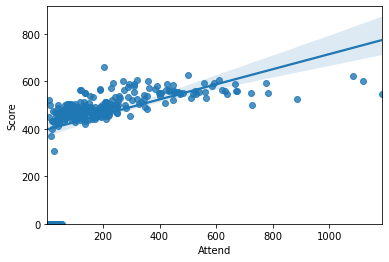

In [118]:
# change 'Attend' column from object to float
brisbane_school_score["Attend"] = brisbane_school_score.Attend.astype(float)
# Attend as potential predictor variable of Score
sns.regplot(x="Attend", y="Score", data=brisbane_school_score)
plt.ylim(0,)

In [119]:
brisbane_school_score[['Attend','Score']].corr()

,Attend,Score
Attend,1.000000,0.472912
Score,0.472912,1.000000


**There is not a very strong correlation, so 'Attend' will not be included in the features**

In [120]:
brisbane_schools_merged = pd.merge(brisbane_schools, brisbane_school_score,  how='left', left_on=['School','Locality'], right_on = ['School','Locality'])
brisbane_schools_merged.head()

,Postcode,School,Locality,Type,School Latitude,School Longitude,Suburb,Locality Lower,Attend,Score,Percent
0,4064,Albert Park Flexible Learning Centre,Milton,Non-State School,-27.465900,153.010813,NaN,NaN,NaN,NaN,NaN
1,4157,Alexandra Hills State High School,Capalaba,State High School,-27.523768,153.215428,NaN,NaN,NaN,NaN,NaN
2,4161,Alexandra Hills State School,Alexandra Hills,State School,-27.518141,153.221279,ALEXANDRA HILLS,alexandra hills,46.0,430.00,94.80
3,4115,Algester State School,Algester,State School,-27.615675,153.031915,ALGESTER,algester,249.0,465.00,98.80
4,4000,All Hallows' School,Brisbane,Non-State School,-27.460894,153.032816,BRISBANE,brisbane,556.0,592.33,99.87


In [121]:
# drop columns not needed
# 'Percent' is not needed as 'Score' will be used to rate schools instead
brisbane_schools_merged.drop(['Suburb', 'Locality Lower', 'Percent'], axis=1, inplace=True) 

In [122]:
# drop rows if there are any blank scores
brisbane_schools_merged = brisbane_schools_merged.dropna(subset = ["Score"], inplace=False).reset_index(drop=True)
brisbane_schools_merged.head()

,Postcode,School,Locality,Type,School Latitude,School Longitude,Attend,Score
0,4161,Alexandra Hills State School,Alexandra Hills,State School,-27.518141,153.221279,46.0,430.00
1,4115,Algester State School,Algester,State School,-27.615675,153.031915,249.0,465.00
2,4000,All Hallows' School,Brisbane,Non-State School,-27.460894,153.032816,556.0,592.33
3,4068,Ambrose Treacy College,Indooroopilly,Non-State School,-27.507571,152.966903,452.0,551.87
4,4006,Angelorum College,Fortitude Valley,Non-State School,-27.455604,153.032768,8.0,0.00


In [123]:
brisbane_schools_merged.shape

(196, 8)

In [124]:
schools = brisbane_schools_merged

In [125]:
# drop rows if no score for a school
schools = schools.dropna(subset = ["Score"], inplace=False).reset_index(drop=True)

In [126]:
# check which column datatypes needed changing
schools.dtypes

Postcode              int64
School               object
Locality             object
Type                 object
School Latitude     float64
School Longitude    float64
Attend              float64
Score               float64
dtype: object

In [127]:
# change 'Attend' column from object to float
schools["Attend"] = schools.Attend.astype(float)

In [128]:
# work out the correct condition to drop these rows
# want to remove schools with score of zero (i.e. they didn't sit the test)
rows_to_drop = schools[(schools['Score'] == 0)]
print(rows_to_drop)

     Postcode                             School          Locality  \
4        4006                  Angelorum College  Fortitude Valley   
29       4116           Calamvale Special School         Calamvale   
43       4179       Darling Point Special School             Manly   
50       4034             Geebung Special School           Geebung   
56       4174   Hemmant Flexible Learning Centre           Hemmant   
71       4112              Kuraby Special School            Kuraby   
77       4156     Mackenzie State Special School         Mackenzie   
87       4068          Milpera State High School           Chelmer   
97       4102    Narbethong State Special School           Buranda   
102      4121  Nursery Road State Special School      Holland Park   
112      4059            Red Hill Special School          Red Hill   
171      4109           Sunnybank Special School         Sunnybank   

                  Type  School Latitude  School Longitude  Attend  Score  
4     Non-Stat

In [137]:
# get names of indexes and remove those rows
index_names = rows_to_drop.index
  
# drop these row indexes
# from dataFrame
schools.drop(index_names, inplace = True)

print(rows_to_drop['School'].count(), 'schools were dropped because they had no performance data')

12 schools were dropped because they had no performance data


In [139]:
print('There are', schools.shape[0], 'Brisbane schools with performance data (including non-state schools)')

There are 184 Brisbane schools with performance data (including non-state schools)


**Remove non-state schools...**

In [140]:
# find out unique values for school 'Type'
schools['Type'].unique()

array(['State School', 'Non-State School', 'State High School'],
      dtype=object)

In [141]:
# change 'State High School' to 'State School' so there are only two unique values
schools['Type'] = schools['Type'].str.replace('State High School','State School')
schools['Type'].unique()

array(['State School', 'Non-State School'], dtype=object)

In [142]:
# simply Type
# 'State School' to 'State'
schools['Type'] = schools['Type'].str.replace('State School','State')
# 'Non-State School' to 'Non-State'
schools['Type'] = schools['Type'].str.replace('Non-State School','Non-State')
schools['Type'].unique()

array(['State', 'Non-State'], dtype=object)

In [143]:
# work out the correct condition to drop these rows
# want to remove schools with score of zero (i.e. they didn't sit the test)
rows_to_drop = schools[(schools['Type'] == 'Non-State')]
print(rows_to_drop)

     Postcode                                 School             Locality  \
2        4000                    All Hallows' School             Brisbane   
3        4068                 Ambrose Treacy College        Indooroopilly   
5        4169         Anglican Church Grammar School        East Brisbane   
20       4068                      Brigidine College        Indooroopilly   
21       4066                 Brisbane Boys' College              Toowong   
23       4107             Brisbane Christian College            Salisbury   
24       4000          Brisbane Girls Grammar School             Brisbane   
25       4000                Brisbane Grammar School             Brisbane   
35       4152           Citipointe Christian College            Carindale   
36       4011                      Clayfield College            Clayfield   
49       4165      Faith Lutheran College - Redlands       Victoria Point   
53       4178        Guardian Angels' Primary School               Wynnum   

In [144]:
# get names of indexes and remove those rows
index_names = rows_to_drop.index
  
# drop these row indexes
# from dataFrame
schools.drop(index_names, inplace = True)

# reset index
schools = schools.reset_index()

# drop old index column
schools = schools.drop('index', 1)

print(rows_to_drop['School'].count(), 'schools were dropped because they were not state schools')

75 schools were dropped because they were not state schools


In [147]:
schools.head()

,Postcode,School,Locality,Type,School Latitude,School Longitude,Attend,Score
0,4161,Alexandra Hills State School,Alexandra Hills,State,-27.518141,153.221279,46.0,430.0
1,4115,Algester State School,Algester,State,-27.615675,153.031915,249.0,465.0
2,4007,Ascot State School,Ascot,State,-27.432671,153.055952,223.0,486.3
3,4034,Aspley East State School,Aspley,State,-27.362313,153.023968,248.0,464.6
4,4034,Aspley State High School,Aspley,State,-27.357169,153.024213,404.0,548.7


In [148]:
print('There are', schools.shape[0], 'Brisbane state schools with performance data')

There are 109 Brisbane state schools with performance data


**Convert 'Score' from numerical to categorical data to prepare for k-means**

In [149]:
mean(schools['Score'])

481.1724770642202

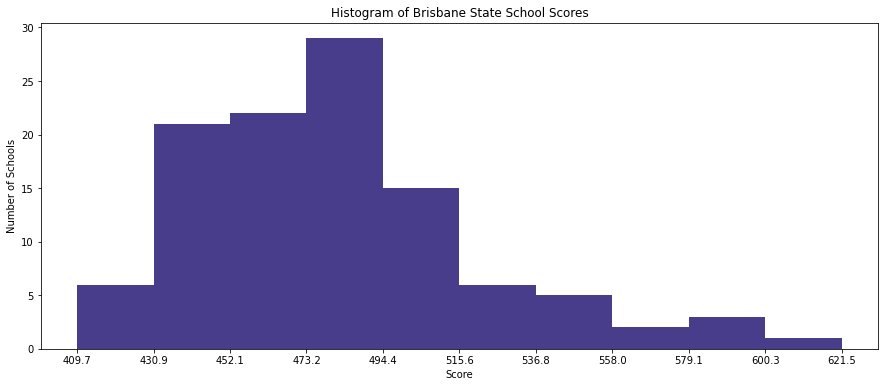

In [124]:
count, bin_edges = np.histogram(schools['Score'], 10)
xmin = bin_edges[0] - 10   #  first bin value is 31.0, adding buffer of 10 for aesthetic purposes 
xmax = bin_edges[-1] + 10  #  last bin value is 308.0, adding buffer of 10 for aesthetic purposes

# stacked Histogram
schools['Score'].plot(kind='hist',
          figsize=(15, 6), 
          bins=10,
          xticks=bin_edges,
          color=['darkslateblue', 'coral', 'mediumseagreen'],
          stacked=True,
          xlim=(xmin, xmax)
         )

plt.title('Histogram of Brisbane State School Scores')
plt.ylabel('Number of Schools')
plt.xlabel('Score') 

plt.show()

In [125]:
#add a new column category next to the Score column
category = pd.cut(schools['Score'],bins=[409.7,430.9,452.1,473.2,494.4,515.6,536.8,558,579.1,600.3,621.5], labels=['Significantly Below Average','Moderately Below Average','Slightly Below Average','Average','Slightly Above Average','Moderately Above Average','Significantly Above Average','Moderately Below Top Rated','Slightly Below Top Rated','Top Rated'])
schools.insert(7,'Rating',category)

In [126]:
schools.head()

,Postcode,School,Locality,Type,School Latitude,School Longitude,Attend,Rating,Score
0,4161,Alexandra Hills State School,Alexandra Hills,State,-27.518141,153.221279,46.0,Significantly Below Average,430.0
1,4115,Algester State School,Algester,State,-27.615675,153.031915,249.0,Slightly Below Average,465.0
2,4007,Ascot State School,Ascot,State,-27.432671,153.055952,223.0,Average,486.3
3,4034,Aspley East State School,Aspley,State,-27.362313,153.023968,248.0,Slightly Below Average,464.6
4,4034,Aspley State High School,Aspley,State,-27.357169,153.024213,404.0,Significantly Above Average,548.7


**Convert 'Attend' from numerical to categorical data to prepare for k-means**

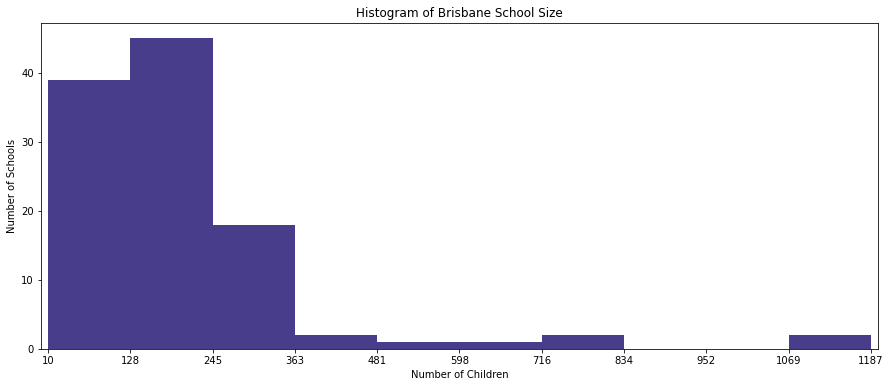

In [127]:
count, bin_edges = np.histogram(schools['Attend'], 10)
xmin = bin_edges[0] - 10   #  first bin value is 31.0, adding buffer of 10 for aesthetic purposes 
xmax = bin_edges[-1] + 10  #  last bin value is 308.0, adding buffer of 10 for aesthetic purposes

# stacked Histogram
schools['Attend'].plot(kind='hist',
          figsize=(15, 6), 
          bins=10,
          xticks=bin_edges,
          color=['darkslateblue', 'coral', 'mediumseagreen'],
          stacked=True,
          xlim=(xmin, xmax)
         )

plt.title('Histogram of Brisbane School Size')
plt.ylabel('Number of Schools')
plt.xlabel('Number of Children') 

plt.show()

In [128]:
#add a new column category next to the Score column
category = pd.cut(schools['Attend'],bins=[0,128,245,363,481,598,716,834,952,1069,1187], labels=['Extremely Small','Very Small','Moderately Small','Fairly Small','Medium','Fairly Large','Moderately Large','Very Large','Very Very Large','Extremely Large'])
schools.insert(6,'Size',category)

In [129]:
schools.head()

,Postcode,School,Locality,Type,School Latitude,School Longitude,Size,Attend,Rating,Score
0,4161,Alexandra Hills State School,Alexandra Hills,State,-27.518141,153.221279,Extremely Small,46.0,Significantly Below Average,430.0
1,4115,Algester State School,Algester,State,-27.615675,153.031915,Moderately Small,249.0,Slightly Below Average,465.0
2,4007,Ascot State School,Ascot,State,-27.432671,153.055952,Very Small,223.0,Average,486.3
3,4034,Aspley East State School,Aspley,State,-27.362313,153.023968,Moderately Small,248.0,Slightly Below Average,464.6
4,4034,Aspley State High School,Aspley,State,-27.357169,153.024213,Fairly Small,404.0,Significantly Above Average,548.7


## Prepare merged school/performance data for one-hot encoding

In [130]:
schools_condensed = schools[['Postcode','Rating']]
schools_condensed.head()

,Postcode,Rating
0,4161,Significantly Below Average
1,4115,Slightly Below Average
2,4007,Average
3,4034,Slightly Below Average
4,4034,Significantly Above Average


In [131]:
# merge DataFrames to get 'Neighbhourhood' column added
schools_with_neighbourhood = schools_condensed.join(just_postcodes_neighbhourhoods.set_index('Postcode'), how='right', on='Postcode')

# move neighbourhood column to the first column
fixed_columns = [schools_with_neighbourhood.columns[-1]] + list(schools_with_neighbourhood.columns[:-1])
schools_with_neighbourhood = schools_with_neighbourhood[fixed_columns]

# drop 'Postcode' column as not needed
schools_with_neighbourhood = schools_with_neighbourhood.drop('Postcode', 1)

# reset index
schools_with_neighbourhood = schools_with_neighbourhood.reset_index()

# drop old index column
schools_with_neighbourhood = schools_with_neighbourhood.drop('index', 1)

schools_with_neighbourhood.head()

,Neighbourhood,Rating
0,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",Average
1,"NEW FARM, TENERIFFE",NaN
2,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION...",NaN
3,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",Average
4,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",Moderately Below Average


In [132]:
postcodes.head()

,Postcode,Neighbourhood,Longitude,Latitude
0,4000,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",153.022459,-27.468544
1,4005,"NEW FARM, TENERIFFE",153.046752,-27.463097
2,4006,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION...",153.175242,-27.366180
3,4007,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",153.061914,-27.436088
4,4008,"BRISBANE AIRPORT, BULWER ISLAND, MEEANDAH, MYR...",153.136496,-27.397546


In [133]:
# one hot encoding
schools_onehot = pd.get_dummies(schools_with_neighbourhood, columns=["Rating"], prefix=["School"])
schools_onehot.head()

,Neighbourhood,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
0,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",0,0,0,1,0,0,0,0,0,0
1,"NEW FARM, TENERIFFE",0,0,0,0,0,0,0,0,0,0
2,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION...",0,0,0,0,0,0,0,0,0,0
3,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",0,0,0,1,0,0,0,0,0,0
4,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",0,1,0,0,0,0,0,0,0,0


In [134]:
# group rows by postcode and by taking the mean of the frequency of occurrence of each category
schools_grouped = schools_onehot.groupby('Neighbourhood').mean().reset_index()
schools_grouped.head()

,Neighbourhood,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
0,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",0.000000,0.000000,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0
2,ALEXANDRA HILLS,0.333333,0.666667,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,"ALGESTER, PARKINSON",0.000000,0.000000,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,"ALTANDI, BANOON, MACGREGOR, ROBERTSON, SUNNYBA...",0.000000,0.250000,0.0,0.0,0.5,0.25,0.0,0.0,0.0,0.0


In [135]:
# function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [136]:
# group rows by postcode and by taking the mean of the frequency of occurrence of each category

# create the new dataframe and display the top 10 schools for each neighbourhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common School'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common School'.format(ind+1))

# create a new dataframe
neighbourhoods_schools_sorted = pd.DataFrame(columns=columns)
neighbourhoods_schools_sorted['Neighbourhood'] = schools_grouped['Neighbourhood']

for ind in np.arange(schools_grouped.shape[0]):
    neighbourhoods_schools_sorted.iloc[ind, 1:] = return_most_common_venues(schools_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_schools_sorted.head(10)

,Neighbourhood,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
0,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
1,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",School_Slightly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
2,ALEXANDRA HILLS,School_Moderately Below Average,School_Significantly Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
3,"ALGESTER, PARKINSON",School_Slightly Below Average,School_Significantly Below Average,School_Moderately Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
4,"ALTANDI, BANOON, MACGREGOR, ROBERTSON, SUNNYBA...",School_Slightly Above Average,School_Moderately Below Average,School_Moderately Above Average,School_Significantly Below Average,School_Slightly Below Average,School_Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
5,"AMITY, AMITY POINT, DUNWICH, NORTH STRADBROKE ...",School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
6,"ANNERLEY, ANNERLEY DC, FAIRFIELD, FAIRFIELD GA...",School_Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
7,"ARCHERFIELD, ARCHERFIELD BC, COOPERS PLAINS",School_Moderately Below Average,School_Significantly Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
8,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",School_Moderately Below Average,School_Average,School_Significantly Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
9,"ASHGROVE, ASHGROVE WEST, DORRINGTON, ST JOHNS ...",School_Slightly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated


In [137]:
# Drop rows which contain any NaN values
# neighbourhoods_schools_sorted = neighbourhoods_schools_sorted.dropna()

# reset index
neighbourhoods_schools_sorted = neighbourhoods_schools_sorted.reset_index()

# drop old index column
neighbourhoods_schools_sorted = neighbourhoods_schools_sorted.drop('index', 1)

neighbourhoods_schools_sorted.head()

,Neighbourhood,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
0,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
1,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",School_Slightly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
2,ALEXANDRA HILLS,School_Moderately Below Average,School_Significantly Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
3,"ALGESTER, PARKINSON",School_Slightly Below Average,School_Significantly Below Average,School_Moderately Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
4,"ALTANDI, BANOON, MACGREGOR, ROBERTSON, SUNNYBA...",School_Slightly Above Average,School_Moderately Below Average,School_Moderately Above Average,School_Significantly Below Average,School_Slightly Below Average,School_Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated


In [138]:
neighbourhoods_schools_sorted.shape

(74, 11)

## Visualize Brisbane neighborhoods and show how they cluster together

**Create a map of Brisbane with neighbourhoods superimposed on top**

In [139]:
address = 'Brisbane'

geolocator = Nominatim(user_agent="brisbane_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brisbane are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brisbane are -27.4689682, 153.0234991.


**Create a map of Brisbane with the schools superimposed on top**

In [140]:
# create map of Brisbane using latitude and longitude values
map_brisbane_schools = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for school_name, postcode, lat, lng, locality in zip(schools['School'], schools['Postcode'], schools['School Latitude'], schools['School Longitude'], schools['Locality']):
    label = '{}, {} {}'.format(school_name, locality, postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brisbane_schools)  
    
map_brisbane_schools

In [141]:
postcodes.head()

,Postcode,Neighbourhood,Longitude,Latitude
0,4000,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",153.022459,-27.468544
1,4005,"NEW FARM, TENERIFFE",153.046752,-27.463097
2,4006,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION...",153.175242,-27.366180
3,4007,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",153.061914,-27.436088
4,4008,"BRISBANE AIRPORT, BULWER ISLAND, MEEANDAH, MYR...",153.136496,-27.397546


In [144]:
# create map of Brisbane using latitude and longitude values
map_brisbane = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for postcode, lat, lng, suburbs in zip(postcodes['Postcode'], postcodes['Latitude'], postcodes['Longitude'], postcodes['Neighbourhood']):
    label = '{}: {}'.format(postcode, suburbs)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brisbane)  
    
map_brisbane

### Use Foursquare API to get the top venues for each neighbourhood

In [145]:
CLIENT_ID = 'QX5S2PBXBBYJQFFFCTJUCYY0WCZC52WJGP4Z04LPWMH5PZ03' # your Foursquare ID
CLIENT_SECRET = 'WJMHCJY25OQOG1F34DZE1Y0RJWMGOH5EP5E052BYU5JESYGR' # your Foursquare Secret
ACCESS_TOKEN = 'RFLADLE0DBAIPYKWSZH0LFEKGIAGGMQSGLR5LKHEP203BUIG' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QX5S2PBXBBYJQFFFCTJUCYY0WCZC52WJGP4Z04LPWMH5PZ03
CLIENT_SECRET:WJMHCJY25OQOG1F34DZE1Y0RJWMGOH5EP5E052BYU5JESYGR


In [146]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [147]:
postcodes.head()

,Postcode,Neighbourhood,Longitude,Latitude
0,4000,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",153.022459,-27.468544
1,4005,"NEW FARM, TENERIFFE",153.046752,-27.463097
2,4006,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION...",153.175242,-27.366180
3,4007,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",153.061914,-27.436088
4,4008,"BRISBANE AIRPORT, BULWER ISLAND, MEEANDAH, MYR...",153.136496,-27.397546


In [148]:
temp_neighbourhoods = postcodes['Neighbourhood']
temp_lats = postcodes['Latitude']
temp_longs = postcodes['Longitude']

In [149]:
brisbane_venues = getNearbyVenues(temp_neighbourhoods, temp_lats, temp_longs)

BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE CITY, BRISBANE CITY DC, BRISBANE GPO, BRISBANE-CITY, PARLIAMENT HOUSE, PETRIE TERRACE, SPRING HILL
NEW FARM, TENERIFFE
BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION, FORTITUDE VALLEY, FORTITUDE VALLEY BC, HERSTON, MAYNE, NEWSTEAD
ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HAMILTON CENTRAL, WHINSTANES
BRISBANE AIRPORT, BULWER ISLAND, MEEANDAH, MYRTLETOWN, PINKENBA
EAGLE FARM, EAGLE FARM BC
ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK
CLAYFIELD, EAGLE JUNCTION, HENDRA
NUNDAH, TOOMBUL, WAVELL HEIGHTS, WAVELL HEIGHTS NORTH
NORTHGATE, NORTHGATE MC
BANYO, NUDGEE, NUDGEE BEACH, VIRGINIA, VIRGINIA BC, VIRGINIA DC
BRACKEN RIDGE, BRIGHTON, BRIGHTON EVENTIDE, BRIGHTON NATHAN STREET, DEAGON, NASHVILLE, SANDGATE, SANDGATE DC, SHORNCLIFFE
FITZGIBBON, TAIGUM
BULWER, CAPE MORETON, COWAN COWAN, KOORINGAL, MORETON ISLAND, TANGALOOMA
ROYAL BRISBANE HOSPITAL
EILDON HILL, KALINGA, LUTWYCHE, WINDSOR, WOOLOOWIN
GLEN KEDRON, GORDON PARK, KEDRON
CHERMSIDE, CHERMS

In [150]:
# check the size of the resulting dataframe
print(brisbane_venues.shape)
brisbane_venues.head()

(450, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",-27.468544,153.022459,W Brisbane,-27.470120,153.021970,Hotel
1,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",-27.468544,153.022459,Cartel Coffee,-27.468448,153.024845,Coffee Shop
2,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",-27.468544,153.022459,Museum of Brisbane,-27.469028,153.023837,History Museum
3,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",-27.468544,153.022459,Coffee Iconic,-27.469269,153.021740,Café
4,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",-27.468544,153.022459,Felix for Goodness,-27.469493,153.024300,Café


In [151]:
# check how many venues were returned for each neighbourhood
brisbane_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",12,12,12,12,12,12
"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARKET, THE GRANGE, WILSTON",7,7,7,7,7,7
"ALTANDI, BANOON, MACGREGOR, ROBERTSON, SUNNYBANK, SUNNYBANK HILLS, SUNNYBANK SOUTH",4,4,4,4,4,4
"ANNERLEY, ANNERLEY DC, FAIRFIELD, FAIRFIELD GARDENS, THOMPSON ESTATE",17,17,17,17,17,17
"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HAMILTON CENTRAL, WHINSTANES",17,17,17,17,17,17
"ASHGROVE, ASHGROVE WEST, DORRINGTON, ST JOHNS WOOD",5,5,5,5,5,5
"ASPLEY, BOONDALL, CARSELDINE, GEEBUNG, ZILLMERE",2,2,2,2,2,2
"AUCHENFLOWER, MOUNT COOT-THA, STUARTHOLME, TOOWONG, TOOWONG BC, TOOWONG DC, TORWOOD",2,2,2,2,2,2
BALD HILLS,3,3,3,3,3,3


In [152]:
# find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(brisbane_venues['Venue Category'].unique())))

There are 140 uniques categories.


### Analyze each neighbourhood

In [153]:
# one hot encoding
brisbane_onehot = pd.get_dummies(brisbane_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
brisbane_onehot['Neighbourhood'] = brisbane_venues['Neighbourhood']

# move neighbourhood column to the first column
fixed_columns = [brisbane_onehot.columns[-1]] + list(brisbane_onehot.columns[:-1])
brisbane_onehot = brisbane_onehot[fixed_columns]

brisbane_onehot.head()

,Neighbourhood,Airport,Airport Lounge,American Restaurant,Antique Shop,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Beer Garden,Beer Store,Boat Launch,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Hill,Historic Site,History Museum,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Laundromat,Lebanese Restaurant,Liquor Store,Locksmith,Malay Restaurant,Men's Store,Mexican Restaurant,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Port,Portuguese Restaurant,Print Shop,Pub,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Soccer Field,Sporting Goods Shop,Sports Club,Street Food Gathering,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio
0,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [154]:
# get new DataFrame size
brisbane_onehot.shape

(450, 141)

In [155]:
# group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category
brisbane_grouped = brisbane_onehot.groupby('Neighbourhood').mean().reset_index()
brisbane_grouped

,Neighbourhood,Airport,Airport Lounge,American Restaurant,Antique Shop,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Beer Garden,Beer Store,Boat Launch,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Hill,Historic Site,History Museum,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Laundromat,Lebanese Restaurant,Liquor Store,Locksmith,Malay Restaurant,Men's Store,Mexican Restaurant,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Port,Portuguese Restaurant,Print Shop,Pub,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Soccer Field,Sporting Goods Shop,Sports Club,Street Food Gathering,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio
0,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.083333,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.0,0.000000,0.0,0.083333,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.083333,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.00000,0.000000,0.000000,0.000000,0.00000
1,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.00000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.0,0.0

In [156]:
# join venue data with crime 
# merge DataFrames brisbane_grouped and crime_grouped_with_neighbourhood
venues_and_crime = brisbane_grouped.join(crime_grouped.set_index('Neighbourhood'), how='left', on='Neighbourhood')

# reset index
venues_and_crime = venues_and_crime.reset_index()

# drop old index column
venues_and_crime = venues_and_crime.drop('index', 1)

venues_and_crime.head()

,Neighbourhood,Airport,Airport Lounge,American Restaurant,Antique Shop,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Beer Garden,Beer Store,Boat Launch,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Hill,Historic Site,History Museum,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Laundromat,Lebanese Restaurant,Liquor Store,Locksmith,Malay Restaurant,Men's Store,Mexican Restaurant,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Port,Portuguese Restaurant,Print Shop,Pub,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Soccer Field,Sporting Goods Shop,Sports Club,Street Food Gathering,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio,Crime_Extremely Low,Crime_Very Very Low,Crime_Very Low,Crime_Moderately Low,Crime_Fairly Low,Crime_Fairly High,Crime_Moderately High,Crime_Very High,Crime_Very Very High,Crime_Extremely High
0,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.250000,0.0,0.0,0.0,0.0,0.000000,0.083333,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.083333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.083333,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0
1,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.142857,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.142857,0.000000,0.0,0.0,0.142857,0.0,0.142857,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0
2,"ALTANDI, BANOON, MACGREGOR, ROBERTSON, SUNNYBA...",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,

In [157]:
# join venue_and_crime data with school data
# merge DataFrames venues_and_crime and schools_grouped_with_neighbourhood
brisbane_all_grouped = venues_and_crime.join(schools_grouped.set_index('Neighbourhood'), how='left', on='Neighbourhood')
brisbane_all_grouped.head()

,Neighbourhood,Airport,Airport Lounge,American Restaurant,Antique Shop,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Beer Garden,Beer Store,Boat Launch,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Hill,Historic Site,History Museum,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Laundromat,Lebanese Restaurant,Liquor Store,Locksmith,Malay Restaurant,Men's Store,Mexican Restaurant,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Port,Portuguese Restaurant,Print Shop,Pub,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Soccer Field,Sporting Goods Shop,Sports Club,Street Food Gathering,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio,Crime_Extremely Low,Crime_Very Very Low,Crime_Very Low,Crime_Moderately Low,Crime_Fairly Low,Crime_Fairly High,Crime_Moderately High,Crime_Very High,Crime_Very Very High,Crime_Extremely High,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
0,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.250000,0.0,0.0,0.0,0.0,0.000000,0.083333,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.083333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.083333,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.142857,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000

In [158]:
# get size of new DataFrame
brisbane_all_grouped.shape

(61, 161)

In [159]:
# Drop rows which contain any NaN values
#brisbane_all_grouped = brisbane_all_grouped.dropna()

# replace any NaN with 0
brisbane_all_grouped = brisbane_all_grouped.replace(np.nan,0)

In [160]:
# get size of school DataFrame
schools_grouped.shape

(74, 11)

In [161]:
# get size of crime DataFrame
crime_grouped.shape

(74, 11)

In [162]:
# get size of new DataFrame
brisbane_all_grouped.shape

(61, 161)

**Some school and crime data has been lost because there was no venue information about those postcodes (so they were dropped in the join)**

In [163]:
# print each neighbourhood along with the top 5 most common venues
num_top_venues = 5

for hood in brisbane_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = brisbane_grouped[brisbane_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK----
                 venue  freq
0                 Café  0.25
1       Cricket Ground  0.08
2  American Restaurant  0.08
3    Indian Restaurant  0.08
4   Turkish Restaurant  0.08


----ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARKET, THE GRANGE, WILSTON----
             venue  freq
0  Thai Restaurant  0.14
1    Grocery Store  0.14
2      Pizza Place  0.14
3             Café  0.14
4    Train Station  0.14


----ALTANDI, BANOON, MACGREGOR, ROBERTSON, SUNNYBANK, SUNNYBANK HILLS, SUNNYBANK SOUTH----
               venue  freq
0      Grocery Store  0.25
1    Nature Preserve  0.25
2      Train Station  0.25
3  Korean Restaurant  0.25
4  Other Repair Shop  0.00


----ANNERLEY, ANNERLEY DC, FAIRFIELD, FAIRFIELD GARDENS, THOMPSON ESTATE----
           venue  freq
0           Café  0.18
1       Pharmacy  0.12
2    Supermarket  0.12
3  Grocery Store  0.06
4  Shopping Mall  0.06


----ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HAMILTON CENTRAL, WH

### Put top venues for each neighbourhood into a pandas dataframe

In [164]:
# create the new dataframe and display the top 10 venues for each neighbourhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = brisbane_grouped['Neighbourhood']

for ind in np.arange(brisbane_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(brisbane_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.tail(50)

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"BANYO, NUDGEE, NUDGEE BEACH, VIRGINIA, VIRGINI...",Locksmith,Airport,Men's Store,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop
12,"BARDON, BARDON WEST, JUBILEE, RAINWORTH",Soccer Field,Playground,Convenience Store,Café,Tennis Court,Neighborhood,Motel,Multiplex,Music Store,Nature Preserve
13,"BAROONA, MILTON, MILTON BC, PADDINGTON, ROSALIE",Italian Restaurant,Thai Restaurant,Ice Cream Shop,Indian Restaurant,Asian Restaurant,Vietnamese Restaurant,Indie Movie Theater,Restaurant,Japanese Restaurant,Burger Joint
14,"BELMONT, BELMONT HEIGHTS",Gun Range,Athletics & Sports,Trail,Bowling Alley,Pharmacy,Pier,Performing Arts Venue,Pedestrian Plaza,Park,Pizza Place
15,BIRKDALE,Flower Shop,Farmers Market,Airport,Organic Grocery,Multiplex,Music Store,Nature Preserve,Neighborhood,Other Repair Shop,Mexican Restaurant
16,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION...",Port,Harbor / Marina,Airport,Other Repair Shop,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery
17,"BRACKEN RIDGE, BRIGHTON, BRIGHTON EVENTIDE, BR...",Beer Garden,Airport,Men's Store,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop
18,BRISBANE,Cosmetics Shop,Convenience Store,Construction & Landscaping,Train Station,Soccer Field,Other Repair Shop,Multiplex,Music Store,Nature Preserve,Neighborhood
19,"BRISBANE AIRPORT, BULWER ISLAND, MEEANDAH, MYR...",Burger Joint,Sandwich Place,Airport,Plaza,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop
20,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",Café,Coffee Shop,Hotel,Thai Restaurant,Korean Restaurant,Australian Restaurant,Mexican Restaurant,Shopping Mall,Burger Joint,Chocolate Shop


###  Cluster neighbourhoods using K-means using venue, crime and school data

In [165]:
brisbane_all_grouped.head()

,Neighbourhood,Airport,Airport Lounge,American Restaurant,Antique Shop,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Beer Garden,Beer Store,Boat Launch,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Hill,Historic Site,History Museum,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Laundromat,Lebanese Restaurant,Liquor Store,Locksmith,Malay Restaurant,Men's Store,Mexican Restaurant,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Port,Portuguese Restaurant,Print Shop,Pub,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Soccer Field,Sporting Goods Shop,Sports Club,Street Food Gathering,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio,Crime_Extremely Low,Crime_Very Very Low,Crime_Very Low,Crime_Moderately Low,Crime_Fairly Low,Crime_Fairly High,Crime_Moderately High,Crime_Very High,Crime_Very Very High,Crime_Extremely High,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
0,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.250000,0.0,0.0,0.0,0.0,0.000000,0.083333,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.083333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.083333,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.142857,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000

In [166]:
brisbane_all_grouped.shape

(61, 161)

In [167]:
# check there for values of NaN
brisbane_all_grouped.columns[brisbane_all_grouped.isna().any()].tolist()

[]

In [168]:
# replace any NaN with 0 otherwise k-means will not work
brisbane_all_grouped = brisbane_all_grouped.replace(np.nan,0)

In [169]:
# create new index column
brisbane_all_grouped = brisbane_all_grouped.reset_index()
# drop old index column
# brisbane_all_grouped = brisbane_all_grouped.drop('level_0', 1)
brisbane_all_grouped = brisbane_all_grouped.drop('index', 1)
brisbane_all_grouped.head()

,Neighbourhood,Airport,Airport Lounge,American Restaurant,Antique Shop,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Beer Garden,Beer Store,Boat Launch,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Hill,Historic Site,History Museum,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Laundromat,Lebanese Restaurant,Liquor Store,Locksmith,Malay Restaurant,Men's Store,Mexican Restaurant,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Port,Portuguese Restaurant,Print Shop,Pub,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Soccer Field,Sporting Goods Shop,Sports Club,Street Food Gathering,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio,Crime_Extremely Low,Crime_Very Very Low,Crime_Very Low,Crime_Moderately Low,Crime_Fairly Low,Crime_Fairly High,Crime_Moderately High,Crime_Very High,Crime_Very Very High,Crime_Extremely High,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
0,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.250000,0.0,0.0,0.0,0.0,0.000000,0.083333,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.083333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.083333,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.142857,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00000

In [170]:
# these lists hold the result values for each k
sse_list = []

max_k_to_try = 20

# train model, predict results, and evaluate using k from 1 to 9
for k in range(1, max_k_to_try):
    # set number of clusters
    kclusters = k

    brisbane_all_grouped_clustering = brisbane_all_grouped.drop('Neighbourhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brisbane_all_grouped_clustering)
    sse_list.append(kmeans.inertia_)

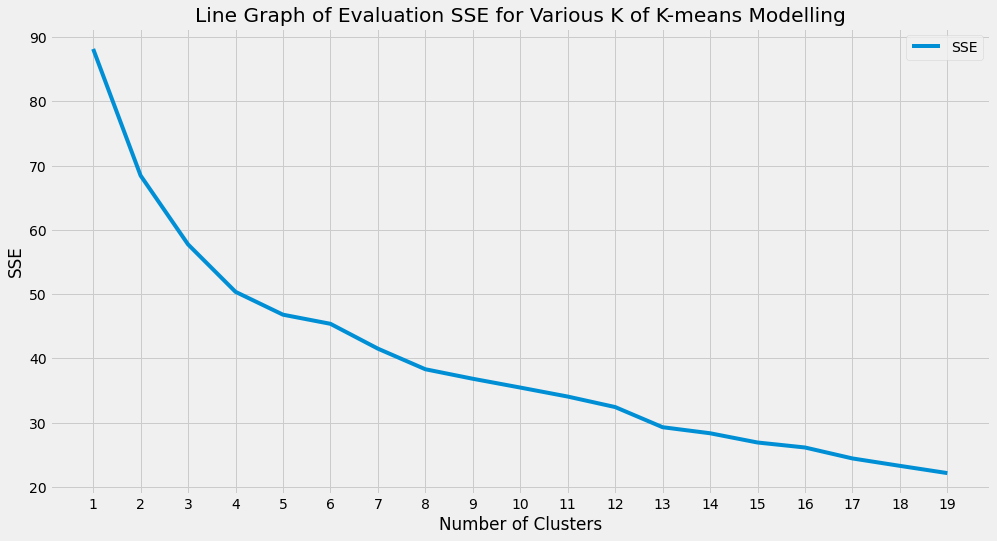

In [171]:
# setup plot for accuracy evaluation metrics
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8)) 
plt.plot(range(1, max_k_to_try), sse_list, label='SSE')
plt.xticks(range(1, max_k_to_try))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Line Graph of Evaluation SSE for Various K of K-means Modelling')
plt.legend() 
plt.show()

## Deciding on a value of k

Using the 'elbow method', it is difficult to decide on a clear winner with k as there is no obvious elbow.  However, we want to use the low SSE while finding a slight elbow.  There are slight elbows at k=4, 6 and 9.  I have chosen k=9 because reporting on more than 9 clusters is too time-consuming.

In [172]:
# use evaluation to now use best value of k
# set number of clusters
kclusters = 8

brisbane_all_grouped_clustering = brisbane_all_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brisbane_all_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 4, 0, 0, 5, 4, 0, 7, 6])

In [173]:
brisbane_all_grouped_clustering.head()

,Airport,Airport Lounge,American Restaurant,Antique Shop,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Beer Garden,Beer Store,Boat Launch,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cricket Ground,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dumpling Restaurant,Electronics Store,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Hill,Historic Site,History Museum,Home Service,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Korean Restaurant,Lake,Laundromat,Lebanese Restaurant,Liquor Store,Locksmith,Malay Restaurant,Men's Store,Mexican Restaurant,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pharmacy,Pier,Pizza Place,Playground,Plaza,Pool,Port,Portuguese Restaurant,Print Shop,Pub,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Salad Place,Sandwich Place,Seafood Restaurant,Shopping Mall,Soccer Field,Sporting Goods Shop,Sports Club,Street Food Gathering,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Shop,Women's Store,Yoga Studio,Crime_Extremely Low,Crime_Very Very Low,Crime_Very Low,Crime_Moderately Low,Crime_Fairly Low,Crime_Fairly High,Crime_Moderately High,Crime_Very High,Crime_Very Very High,Crime_Extremely High,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.250000,0.0,0.0,0.0,0.0,0.000000,0.083333,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.083333,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.083333,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.142857,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.142857,0.000000,0.0,0.0,0.142857,0.0,0.142857,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0

**Get postcode data ready to help with clusters analysis...**

In [174]:
# create new index column
postcodes = postcodes.reset_index()
# drop old index column
# postcodes = postcodes.drop('level_0', 1)
postcodes = postcodes.drop('index', 1)
postcodes.head()

,Postcode,Neighbourhood,Longitude,Latitude
0,4000,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",153.022459,-27.468544
1,4005,"NEW FARM, TENERIFFE",153.046752,-27.463097
2,4006,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION...",153.175242,-27.366180
3,4007,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",153.061914,-27.436088
4,4008,"BRISBANE AIRPORT, BULWER ISLAND, MEEANDAH, MYR...",153.136496,-27.397546


**Get venue data ready to analyse against clusters...**

In [175]:
# run if clustering labels was already added
#neighbourhoods_venues_sorted = neighbourhoods_venues_sorted.drop('Cluster Labels', 1)

In [176]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

brisbane_merged_venues = postcodes
brisbane_merged_venues.rename(columns = {'Suburb': 'Neighbourhood'}, inplace = True)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighbourhood
brisbane_merged_venues = brisbane_merged_venues.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), how='right', on='Neighbourhood')

brisbane_merged_venues.head() # check the last columns!

,Postcode,Neighbourhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,4010,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",153.043540,-27.433237,1,Café,Cricket Ground,American Restaurant,Indian Restaurant,Turkish Restaurant,Bakery,Pub,Recording Studio,Comedy Club,Fast Food Restaurant
20,4051,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",153.000297,-27.427508,0,Thai Restaurant,Grocery Store,Pizza Place,Café,Train Station,Supermarket,Thrift / Vintage Store,Motel,Multiplex,Music Store
39,4109,"ALTANDI, BANOON, MACGREGOR, ROBERTSON, SUNNYBA...",153.057452,-27.579250,4,Grocery Store,Nature Preserve,Train Station,Korean Restaurant,Other Repair Shop,Motel,Multiplex,Music Store,Neighborhood,Organic Grocery
33,4103,"ANNERLEY, ANNERLEY DC, FAIRFIELD, FAIRFIELD GA...",153.028768,-27.512175,0,Café,Pharmacy,Supermarket,Grocery Store,Shopping Mall,Sporting Goods Shop,Restaurant,Liquor Store,Coffee Shop,Thai Restaurant
3,4007,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",153.061914,-27.436088,0,Pizza Place,Burger Joint,Liquor Store,Bus Stop,Bus Station,Sandwich Place,Breakfast Spot,Sushi Restaurant,Convenience Store,Grocery Store


**Get school data ready to analyse against clusters...**

In [177]:
# only get schools for postcodes in dataset of venues, crimes, and schools
neighbourhoods_schools_resorted = brisbane_all_grouped[['Neighbourhood']]

# merge with schools
neighbourhoods_schools_resorted = neighbourhoods_schools_resorted.join(neighbourhoods_schools_sorted.set_index('Neighbourhood'), how='left', on='Neighbourhood')

neighbourhoods_schools_resorted.head()

,Neighbourhood,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
0,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
1,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",School_Slightly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
2,"ALTANDI, BANOON, MACGREGOR, ROBERTSON, SUNNYBA...",School_Slightly Above Average,School_Moderately Below Average,School_Moderately Above Average,School_Significantly Below Average,School_Slightly Below Average,School_Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
3,"ANNERLEY, ANNERLEY DC, FAIRFIELD, FAIRFIELD GA...",School_Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
4,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",School_Moderately Below Average,School_Average,School_Significantly Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated


In [178]:
neighbourhoods_schools_resorted.shape

(61, 11)

In [179]:
# run if clustering labels was already added
#neighbourhoods_schools_resorted = neighbourhoods_schools_resorted.drop('Cluster Labels', 1)

In [180]:
# add clustering labels
neighbourhoods_schools_resorted.insert(0, 'Cluster Labels', kmeans.labels_)

brisbane_merged_schools = postcodes
brisbane_merged_schools.rename(columns = {'Suburb': 'Neighbourhood'}, inplace = True)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighbourhood
brisbane_merged_schools = brisbane_merged_schools.join(neighbourhoods_schools_resorted.set_index('Neighbourhood'), how='right', on='Neighbourhood')

brisbane_merged_schools.head()

,Postcode,Neighbourhood,Longitude,Latitude,Cluster Labels,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
6,4010,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",153.043540,-27.433237,1,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
20,4051,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",153.000297,-27.427508,0,School_Slightly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
39,4109,"ALTANDI, BANOON, MACGREGOR, ROBERTSON, SUNNYBA...",153.057452,-27.579250,4,School_Slightly Above Average,School_Moderately Below Average,School_Moderately Above Average,School_Significantly Below Average,School_Slightly Below Average,School_Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
33,4103,"ANNERLEY, ANNERLEY DC, FAIRFIELD, FAIRFIELD GA...",153.028768,-27.512175,0,School_Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
3,4007,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",153.061914,-27.436088,0,School_Moderately Below Average,School_Average,School_Significantly Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated


In [181]:
brisbane_merged_schools.loc[brisbane_merged_schools['Cluster Labels'] == 0, brisbane_merged_schools.columns[[1] + list(range(5, brisbane_merged_schools.shape[1]))]]

,Neighbourhood,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
20,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",School_Slightly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
33,"ANNERLEY, ANNERLEY DC, FAIRFIELD, FAIRFIELD GA...",School_Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
3,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",School_Moderately Below Average,School_Average,School_Significantly Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
26,"AUCHENFLOWER, MOUNT COOT-THA, STUARTHOLME, TOO...",School_Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
10,"BANYO, NUDGEE, NUDGEE BEACH, VIRGINIA, VIRGINI...",School_Slightly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
49,"CAMP HILL, CARINA, CARINA HEIGHTS, CARINA NORT...",School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Significantly Below Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
59,"CLEVELAND, CLEVELAND DC",School_Slightly Below Average,School_Significantly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
62,"EAST BRISBANE, KANGAROO POINT, STANLEY BRIDGE",School_Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
42,"EIGHT MILE PLAINS, FRUITGROVE, RUNCORN",School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Below Average,School_Slightly Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
15,"EILDON HILL, KALINGA, LUTWYCHE, WINDSOR, WOOLO...",School_Average,School_Slightly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated


**Get crime data ready to analyse against clusters...**

In [182]:
# only get crimes for postcodes in dataset of venues, crimes, and schools
neighbourhoods_crimes_sorted = brisbane_all_grouped[['Neighbourhood']]

# merge with crimes
neighbourhoods_crimes_sorted = neighbourhoods_crimes_sorted.join(crimes_with_neighbourhood.set_index('Neighbourhood'), how='left', on='Neighbourhood')

neighbourhoods_crimes_sorted.head()

,Neighbourhood,Crime Group
0,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",Extremely Low
1,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",Very Low
2,"ALTANDI, BANOON, MACGREGOR, ROBERTSON, SUNNYBA...",Fairly Low
3,"ANNERLEY, ANNERLEY DC, FAIRFIELD, FAIRFIELD GA...",Very Low
4,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",Very Low


In [183]:
neighbourhoods_crimes_sorted.shape

(61, 2)

In [184]:
# run if clustering labels was already added
#neighbourhoods_crimes_sorted = neighbourhoods_crimes_sorted.drop('Cluster Labels', 1)

In [185]:
# add clustering labels
neighbourhoods_crimes_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

brisbane_merged_crimes = postcodes
#brisbane_merged_crimes.rename(columns = {'Suburb': 'Neighbourhood'}, inplace = True)
#brisbane_merged_crimes = brisbane_merged_crimes.drop('Area', 1)

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighbourhood
brisbane_merged_crimes = brisbane_merged_crimes.join(neighbourhoods_crimes_sorted.set_index('Neighbourhood'), how='right', on='Neighbourhood')

brisbane_merged_crimes.head() # check the last columns!

,Postcode,Neighbourhood,Longitude,Latitude,Cluster Labels,Crime Group
6,4010,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",153.043540,-27.433237,1,Extremely Low
20,4051,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",153.000297,-27.427508,0,Very Low
39,4109,"ALTANDI, BANOON, MACGREGOR, ROBERTSON, SUNNYBA...",153.057452,-27.579250,4,Fairly Low
33,4103,"ANNERLEY, ANNERLEY DC, FAIRFIELD, FAIRFIELD GA...",153.028768,-27.512175,0,Very Low
3,4007,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",153.061914,-27.436088,0,Very Low


### Visualise the clusters on the map

In [216]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brisbane_merged_venues['Latitude'], brisbane_merged_venues['Longitude'], brisbane_merged_venues['Neighbourhood'], brisbane_merged_venues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

#### Cluster 0 (red)

**These neighbourhoods a large range of venues and most commonly have schools with average or below average performance.  All these neighbourhoods have very low crime levels.**

In [187]:
brisbane_merged_venues.loc[brisbane_merged_venues['Cluster Labels'] == 0, brisbane_merged_venues.columns[[1] + list(range(5, brisbane_merged_venues.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",Thai Restaurant,Grocery Store,Pizza Place,Café,Train Station,Supermarket,Thrift / Vintage Store,Motel,Multiplex,Music Store
33,"ANNERLEY, ANNERLEY DC, FAIRFIELD, FAIRFIELD GA...",Café,Pharmacy,Supermarket,Grocery Store,Shopping Mall,Sporting Goods Shop,Restaurant,Liquor Store,Coffee Shop,Thai Restaurant
3,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",Pizza Place,Burger Joint,Liquor Store,Bus Stop,Bus Station,Sandwich Place,Breakfast Spot,Sushi Restaurant,Convenience Store,Grocery Store
26,"AUCHENFLOWER, MOUNT COOT-THA, STUARTHOLME, TOO...",Trail,Airport,Organic Grocery,Mexican Restaurant,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Other Repair Shop
10,"BANYO, NUDGEE, NUDGEE BEACH, VIRGINIA, VIRGINI...",Locksmith,Airport,Men's Store,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop
49,"CAMP HILL, CARINA, CARINA HEIGHTS, CARINA NORT...",Coffee Shop,Department Store,Thai Restaurant,Airport,Other Repair Shop,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery
59,"CLEVELAND, CLEVELAND DC",Business Service,Park,Gym,Soccer Field,Organic Grocery,Airport,Neighborhood,Motel,Multiplex,Music Store
62,"EAST BRISBANE, KANGAROO POINT, STANLEY BRIDGE",Cricket Ground,Pub,German Restaurant,Fast Food Restaurant,Liquor Store,Burger Joint,Recording Studio,Coffee Shop,Convenience Store,Antique Shop
42,"EIGHT MILE PLAINS, FRUITGROVE, RUNCORN",Pool,Other Repair Shop,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Paper / Office Supplies Store,Men's Store
15,"EILDON HILL, KALINGA, LUTWYCHE, WINDSOR, WOOLO...",Theater,Electronics Store,Convenience Store,Liquor Store,Gym,Pub,Music Store,Nature Preserve,Neighborhood,Organic Grocery


In [188]:
brisbane_merged_schools.loc[brisbane_merged_schools['Cluster Labels'] == 0, brisbane_merged_schools.columns[[1] + list(range(5, brisbane_merged_schools.shape[1]))]]

,Neighbourhood,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
20,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",School_Slightly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
33,"ANNERLEY, ANNERLEY DC, FAIRFIELD, FAIRFIELD GA...",School_Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
3,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",School_Moderately Below Average,School_Average,School_Significantly Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
26,"AUCHENFLOWER, MOUNT COOT-THA, STUARTHOLME, TOO...",School_Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
10,"BANYO, NUDGEE, NUDGEE BEACH, VIRGINIA, VIRGINI...",School_Slightly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
49,"CAMP HILL, CARINA, CARINA HEIGHTS, CARINA NORT...",School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Significantly Below Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
59,"CLEVELAND, CLEVELAND DC",School_Slightly Below Average,School_Significantly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
62,"EAST BRISBANE, KANGAROO POINT, STANLEY BRIDGE",School_Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
42,"EIGHT MILE PLAINS, FRUITGROVE, RUNCORN",School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Below Average,School_Slightly Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
15,"EILDON HILL, KALINGA, LUTWYCHE, WINDSOR, WOOLO...",School_Average,School_Slightly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated


In [189]:
brisbane_merged_crimes.loc[brisbane_merged_crimes['Cluster Labels'] == 0, brisbane_merged_crimes.columns[[1] + list(range(5, brisbane_merged_crimes.shape[1]))]]

,Neighbourhood,Crime Group
20,"ALDERLEY, ENOGGERA, GAYTHORNE, GRANGE, NEWMARK...",Very Low
33,"ANNERLEY, ANNERLEY DC, FAIRFIELD, FAIRFIELD GA...",Very Low
3,"ASCOT, BRISBANE AIRPORT, DOOMBEN, HAMILTON, HA...",Very Low
26,"AUCHENFLOWER, MOUNT COOT-THA, STUARTHOLME, TOO...",Very Low
10,"BANYO, NUDGEE, NUDGEE BEACH, VIRGINIA, VIRGINI...",Very Low
49,"CAMP HILL, CARINA, CARINA HEIGHTS, CARINA NORT...",Very Low
59,"CLEVELAND, CLEVELAND DC",Very Low
62,"EAST BRISBANE, KANGAROO POINT, STANLEY BRIDGE",Very Low
42,"EIGHT MILE PLAINS, FRUITGROVE, RUNCORN",Very Low
15,"EILDON HILL, KALINGA, LUTWYCHE, WINDSOR, WOOLO...",Very Low


#### Cluster 1 (purple)

**These neighbourhoods most commonly have schools performing moderately or significantly below average.  All have extremely low crime.  They have a large range of venues.**

In [190]:
brisbane_merged_venues.loc[brisbane_merged_venues['Cluster Labels'] == 1, brisbane_merged_venues.columns[[1] + list(range(5, brisbane_merged_venues.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",Café,Cricket Ground,American Restaurant,Indian Restaurant,Turkish Restaurant,Bakery,Pub,Recording Studio,Comedy Club,Fast Food Restaurant
50,"BELMONT, BELMONT HEIGHTS",Gun Range,Athletics & Sports,Trail,Bowling Alley,Pharmacy,Pier,Performing Arts Venue,Pedestrian Plaza,Park,Pizza Place
56,BIRKDALE,Flower Shop,Farmers Market,Airport,Organic Grocery,Multiplex,Music Store,Nature Preserve,Neighborhood,Other Repair Shop,Mexican Restaurant
4,"BRISBANE AIRPORT, BULWER ISLAND, MEEANDAH, MYR...",Burger Joint,Sandwich Place,Airport,Plaza,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop
52,CHANDLER,Diner,Sporting Goods Shop,Airport,Organic Grocery,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Paper / Office Supplies Store
67,"DOBOY, HEMMANT",Harbor / Marina,Train Station,Airport,Other Repair Shop,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery
5,"EAGLE FARM, EAGLE FARM BC",Airport Lounge,Café,Airport,Rental Car Location,Vietnamese Restaurant,Train Station,Convenience Store,Border Crossing,Coffee Shop,Nature Preserve
57,"EROBIN, ORMISTON, WELLINGTON POINT",Park,Other Repair Shop,Airport,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Paper / Office Supplies Store
72,GRIFFITH UNIVERSITY,Café,Bar,Airport,Mexican Restaurant,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop
40,"GRIFFITH UNIVERSITY, NATHAN",Café,Bar,Airport,Mexican Restaurant,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop


In [191]:
brisbane_merged_schools.loc[brisbane_merged_schools['Cluster Labels'] == 1, brisbane_merged_schools.columns[[1] + list(range(5, brisbane_merged_schools.shape[1]))]]

,Neighbourhood,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
6,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
50,"BELMONT, BELMONT HEIGHTS",School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
56,BIRKDALE,School_Moderately Below Average,School_Slightly Below Average,School_Significantly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
4,"BRISBANE AIRPORT, BULWER ISLAND, MEEANDAH, MYR...",School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
52,CHANDLER,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
67,"DOBOY, HEMMANT",School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
5,"EAGLE FARM, EAGLE FARM BC",School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
57,"EROBIN, ORMISTON, WELLINGTON POINT",School_Moderately Below Average,School_Average,School_Significantly Above Average,School_Significantly Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
72,GRIFFITH UNIVERSITY,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
40,"GRIFFITH UNIVERSITY, NATHAN",School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated


In [192]:
brisbane_merged_crimes.loc[brisbane_merged_crimes['Cluster Labels'] == 1, brisbane_merged_crimes.columns[[1] + list(range(5, brisbane_merged_crimes.shape[1]))]]

,Neighbourhood,Crime Group
6,"ALBION, ALBION BC, ALBION DC, BREAKFAST CREEK",Extremely Low
50,"BELMONT, BELMONT HEIGHTS",Extremely Low
56,BIRKDALE,Extremely Low
4,"BRISBANE AIRPORT, BULWER ISLAND, MEEANDAH, MYR...",Extremely Low
52,CHANDLER,Extremely Low
67,"DOBOY, HEMMANT",Extremely Low
5,"EAGLE FARM, EAGLE FARM BC",Extremely Low
57,"EROBIN, ORMISTON, WELLINGTON POINT",Extremely Low
72,GRIFFITH UNIVERSITY,Extremely Low
40,"GRIFFITH UNIVERSITY, NATHAN",Extremely Low


#### Cluster 2 (dark blue)

**These neighbourhoods most commonly have schools that are below average (however the 2 most common types of schools in the Indooroopily neighbhourhood are performing better than average).  All these neighbourhoods have moderately low crime levels.  They also have a wide range of venues.**

In [193]:
brisbane_merged_venues.loc[brisbane_merged_venues['Cluster Labels'] == 2, brisbane_merged_venues.columns[[1] + list(range(5, brisbane_merged_venues.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"BRACKEN RIDGE, BRIGHTON, BRIGHTON EVENTIDE, BR...",Beer Garden,Airport,Men's Store,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop
32,"BURANDA, DUTTON PARK, PRINCESS ALEXANDRA HOSPI...",Café,Hotel,Pub,Farmers Market,Coffee Shop,Thrift / Vintage Store,Paper / Office Supplies Store,Gym,Historic Site,Park
63,"CANNON HILL, COLMSLIE, MORNINGSIDE, NORMAN PAR...",Indian Restaurant,Pizza Place,Bakery,Malay Restaurant,Laundromat,Thai Restaurant,Coffee Shop,Portuguese Restaurant,Health & Beauty Service,Sandwich Place
28,"CHELMER, INDOOROOPILLY, INDOOROOPILLY CENTRE, ...",Multiplex,Ice Cream Shop,Music Store,Indonesian Restaurant,Train Station,Café,Thai Restaurant,Airport,Other Repair Shop,Nature Preserve
8,"NUNDAH, TOOMBUL, WAVELL HEIGHTS, WAVELL HEIGHT...",Café,Airport,Other Repair Shop,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Paper / Office Supplies Store,Mexican Restaurant


In [194]:
brisbane_merged_schools.loc[brisbane_merged_schools['Cluster Labels'] == 2, brisbane_merged_schools.columns[[1] + list(range(5, brisbane_merged_schools.shape[1]))]]

,Neighbourhood,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
11,"BRACKEN RIDGE, BRIGHTON, BRIGHTON EVENTIDE, BR...",School_Moderately Below Average,School_Significantly Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Slightly Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
32,"BURANDA, DUTTON PARK, PRINCESS ALEXANDRA HOSPI...",School_Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
63,"CANNON HILL, COLMSLIE, MORNINGSIDE, NORMAN PAR...",School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Significantly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Moderately Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
28,"CHELMER, INDOOROOPILLY, INDOOROOPILLY CENTRE, ...",School_Moderately Above Average,School_Slightly Below Top Rated,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Top Rated
8,"NUNDAH, TOOMBUL, WAVELL HEIGHTS, WAVELL HEIGHT...",School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Significantly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated


In [195]:
brisbane_merged_crimes.loc[brisbane_merged_crimes['Cluster Labels'] == 2, brisbane_merged_crimes.columns[[1] + list(range(5, brisbane_merged_crimes.shape[1]))]]

,Neighbourhood,Crime Group
11,"BRACKEN RIDGE, BRIGHTON, BRIGHTON EVENTIDE, BR...",Moderately Low
32,"BURANDA, DUTTON PARK, PRINCESS ALEXANDRA HOSPI...",Moderately Low
63,"CANNON HILL, COLMSLIE, MORNINGSIDE, NORMAN PAR...",Moderately Low
28,"CHELMER, INDOOROOPILLY, INDOOROOPILLY CENTRE, ...",Moderately Low
8,"NUNDAH, TOOMBUL, WAVELL HEIGHTS, WAVELL HEIGHT...",Moderately Low


#### Cluster 3 (light blue)

**These neighbourhoods most commonly have average schools and venues that are cafes or restaurants.  All have very low crime except one neighbhourhood containing the CBD (where there is extremely high crime).**

In [196]:
brisbane_merged_venues.loc[brisbane_merged_venues['Cluster Labels'] == 3, brisbane_merged_venues.columns[[1] + list(range(5, brisbane_merged_venues.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,"BALMORAL, BULIMBA, GALLOWAYS HILL, HAWTHORNE",Mexican Restaurant,Café,Gift Shop,Italian Restaurant,Convenience Store,BBQ Joint,French Restaurant,Sushi Restaurant,Bookstore,Airport
24,"BAROONA, MILTON, MILTON BC, PADDINGTON, ROSALIE",Italian Restaurant,Thai Restaurant,Ice Cream Shop,Indian Restaurant,Asian Restaurant,Vietnamese Restaurant,Indie Movie Theater,Restaurant,Japanese Restaurant,Burger Joint
0,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",Café,Coffee Shop,Hotel,Thai Restaurant,Korean Restaurant,Australian Restaurant,Mexican Restaurant,Shopping Mall,Burger Joint,Chocolate Shop
16,"GLEN KEDRON, GORDON PARK, KEDRON",Café,Fast Food Restaurant,Ice Cream Shop,Bus Stop,River,Bakery,Airport,Nature Preserve,Neighborhood,Organic Grocery
45,"GREENSLOPES, LORETO HILL, STONES CORNER",Park,Hill,Bus Station,Coffee Shop,Paper / Office Supplies Store,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop


In [197]:
brisbane_merged_schools.loc[brisbane_merged_schools['Cluster Labels'] == 3, brisbane_merged_schools.columns[[1] + list(range(5, brisbane_merged_schools.shape[1]))]]

,Neighbourhood,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
64,"BALMORAL, BULIMBA, GALLOWAYS HILL, HAWTHORNE",School_Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
24,"BAROONA, MILTON, MILTON BC, PADDINGTON, ROSALIE",School_Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
0,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",School_Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
16,"GLEN KEDRON, GORDON PARK, KEDRON",School_Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
45,"GREENSLOPES, LORETO HILL, STONES CORNER",School_Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated


In [198]:
brisbane_merged_crimes.loc[brisbane_merged_crimes['Cluster Labels'] == 3, brisbane_merged_crimes.columns[[1] + list(range(5, brisbane_merged_crimes.shape[1]))]]

,Neighbourhood,Crime Group
64,"BALMORAL, BULIMBA, GALLOWAYS HILL, HAWTHORNE",Very Very Low
24,"BAROONA, MILTON, MILTON BC, PADDINGTON, ROSALIE",Very Very Low
0,"BRISBANE, BRISBANE ADELAIDE STREET, BRISBANE C...",Extremely High
16,"GLEN KEDRON, GORDON PARK, KEDRON",Very Very Low
45,"GREENSLOPES, LORETO HILL, STONES CORNER",Very Very Low


#### Cluster 4 (aqua)

**These neighbourhoods have schools with varying performance levels and have a range of venues.  Also, they mostly have high crime levels.**

In [199]:
brisbane_merged_venues.loc[brisbane_merged_venues['Cluster Labels'] == 4, brisbane_merged_venues.columns[[1] + list(range(5, brisbane_merged_venues.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,"ALTANDI, BANOON, MACGREGOR, ROBERTSON, SUNNYBA...",Grocery Store,Nature Preserve,Train Station,Korean Restaurant,Other Repair Shop,Motel,Multiplex,Music Store,Neighborhood,Organic Grocery
18,"ASPLEY, BOONDALL, CARSELDINE, GEEBUNG, ZILLMERE",Liquor Store,Grocery Store,Airport,Other Repair Shop,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Paper / Office Supplies Store
2,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION...",Port,Harbor / Marina,Airport,Other Repair Shop,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery
73,BRISBANE,Cosmetics Shop,Convenience Store,Construction & Landscaping,Train Station,Soccer Field,Other Repair Shop,Multiplex,Music Store,Nature Preserve,Neighborhood
31,"HIGHGATE HILL, MATER HILL, MATER HOSPITAL, SOU...",Coffee Shop,Vietnamese Restaurant,Yoga Studio,Bar,Thai Restaurant,Bookstore,Café,Cocktail Bar,Vegetarian / Vegan Restaurant,Malay Restaurant
47,"MANSFIELD, MANSFIELD BC, MANSFIELD DC, MOUNT G...",Playground,Street Food Gathering,Flea Market,Golf Course,Neighborhood,Motel,Multiplex,Music Store,Nature Preserve,Airport


In [200]:
brisbane_merged_schools.loc[brisbane_merged_schools['Cluster Labels'] == 4, brisbane_merged_schools.columns[[1] + list(range(5, brisbane_merged_schools.shape[1]))]]

,Neighbourhood,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
39,"ALTANDI, BANOON, MACGREGOR, ROBERTSON, SUNNYBA...",School_Slightly Above Average,School_Moderately Below Average,School_Moderately Above Average,School_Significantly Below Average,School_Slightly Below Average,School_Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
18,"ASPLEY, BOONDALL, CARSELDINE, GEEBUNG, ZILLMERE",School_Slightly Below Average,School_Moderately Below Average,School_Average,School_Significantly Above Average,School_Significantly Below Average,School_Slightly Above Average,School_Moderately Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
2,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION...",School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
73,BRISBANE,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
31,"HIGHGATE HILL, MATER HILL, MATER HOSPITAL, SOU...",School_Slightly Above Average,School_Top Rated,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated
47,"MANSFIELD, MANSFIELD BC, MANSFIELD DC, MOUNT G...",School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Significantly Below Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated


In [201]:
brisbane_merged_crimes.loc[brisbane_merged_crimes['Cluster Labels'] == 4, brisbane_merged_crimes.columns[[1] + list(range(5, brisbane_merged_crimes.shape[1]))]]

,Neighbourhood,Crime Group
39,"ALTANDI, BANOON, MACGREGOR, ROBERTSON, SUNNYBA...",Fairly Low
18,"ASPLEY, BOONDALL, CARSELDINE, GEEBUNG, ZILLMERE",Fairly High
2,"BOWEN BRIDGE, BOWEN HILLS, BRISBANE EXHIBITION...",Very Very High
73,BRISBANE,NaN
31,"HIGHGATE HILL, MATER HILL, MATER HOSPITAL, SOU...",Very High
47,"MANSFIELD, MANSFIELD BC, MANSFIELD DC, MOUNT G...",Moderately High


#### Cluster 5 (light green)

**These neighbourhoods most commonly have venues related to fitness, such as soccer fields, sports clubs and gyms.  The most common schools perform slightly above average.  All these neighbourhoods have extremely low crime levels.**

In [202]:
brisbane_merged_venues.loc[brisbane_merged_venues['Cluster Labels'] == 5, brisbane_merged_venues.columns[[1] + list(range(5, brisbane_merged_venues.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,"ASHGROVE, ASHGROVE WEST, DORRINGTON, ST JOHNS ...",Ice Cream Shop,Indian Restaurant,Sports Club,Gym / Fitness Center,Chinese Restaurant,Airport,Organic Grocery,Multiplex,Music Store,Nature Preserve
25,"BARDON, BARDON WEST, JUBILEE, RAINWORTH",Soccer Field,Playground,Convenience Store,Café,Tennis Court,Neighborhood,Motel,Multiplex,Music Store,Nature Preserve
27,"IRONSIDE, ST LUCIA, ST LUCIA SOUTH",Japanese Restaurant,Sandwich Place,Bus Stop,Indian Restaurant,Grocery Store,Thai Restaurant,Other Repair Shop,Multiplex,Music Store,Nature Preserve


In [203]:
brisbane_merged_schools.loc[brisbane_merged_schools['Cluster Labels'] == 5, brisbane_merged_schools.columns[[1] + list(range(5, brisbane_merged_schools.shape[1]))]]

,Neighbourhood,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
22,"ASHGROVE, ASHGROVE WEST, DORRINGTON, ST JOHNS ...",School_Slightly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
25,"BARDON, BARDON WEST, JUBILEE, RAINWORTH",School_Slightly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
27,"IRONSIDE, ST LUCIA, ST LUCIA SOUTH",School_Slightly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated


In [204]:
brisbane_merged_crimes.loc[brisbane_merged_crimes['Cluster Labels'] == 5, brisbane_merged_crimes.columns[[1] + list(range(5, brisbane_merged_crimes.shape[1]))]]

,Neighbourhood,Crime Group
22,"ASHGROVE, ASHGROVE WEST, DORRINGTON, ST JOHNS ...",Extremely Low
25,"BARDON, BARDON WEST, JUBILEE, RAINWORTH",Extremely Low
27,"IRONSIDE, ST LUCIA, ST LUCIA SOUTH",Extremely Low


#### Cluster 6 (orange)

**These neighbourhoods mostly commonly have schools with varying performance.  All these neighbourhoods have 'very very low' crime levels.  They have a range of venues.**

In [205]:
brisbane_merged_venues.loc[brisbane_merged_venues['Cluster Labels'] == 6, brisbane_merged_venues.columns[[1] + list(range(5, brisbane_merged_venues.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,"BALLYMORE, ITHACA, KELVIN GROVE, KELVIN GROVE ...",Bus Stop,Thai Restaurant,Fast Food Restaurant,Indian Restaurant,Wine Shop,Salad Place,Italian Restaurant,Convenience Store,Bakery,Beer Store
44,"CALAMVALE, DREWVALE, STRETTON",Convenience Store,Gas Station,Neighborhood,Business Service,Airport,Other Repair Shop,Music Store,Nature Preserve,Organic Grocery,Paper / Office Supplies Store
7,"CLAYFIELD, EAGLE JUNCTION, HENDRA",Café,Bakery,Portuguese Restaurant,Bus Stop,Seafood Restaurant,Chinese Restaurant,Pizza Place,Fried Chicken Joint,Sushi Restaurant,Grocery Store
35,"CLIFTON HILL, MOOROOKA, MOORVALE, TENNYSON, YE...",Furniture / Home Store,Burger Joint,Café,Thai Restaurant,Organic Grocery,Multiplex,Music Store,Nature Preserve,Neighborhood,Other Repair Shop
48,"COORPAROO, COORPAROO BC, COORPAROO DC",Dance Studio,Café,Thai Restaurant,Organic Grocery,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Airport
46,"EKIBIN, HOLLAND PARK, HOLLAND PARK EAST, HOLLA...",Coffee Shop,Bus Station,Asian Restaurant,Convenience Store,Park,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop,Paper / Office Supplies Store
12,"FITZGIBBON, TAIGUM",Plaza,Golf Course,Train Station,Thai Restaurant,Organic Grocery,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood


In [206]:
brisbane_merged_schools.loc[brisbane_merged_schools['Cluster Labels'] == 6, brisbane_merged_schools.columns[[1] + list(range(5, brisbane_merged_schools.shape[1]))]]

,Neighbourhood,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
21,"BALLYMORE, ITHACA, KELVIN GROVE, KELVIN GROVE ...",School_Significantly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
44,"CALAMVALE, DREWVALE, STRETTON",School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
7,"CLAYFIELD, EAGLE JUNCTION, HENDRA",School_Moderately Below Average,School_Moderately Above Average,School_Moderately Below Top Rated,School_Significantly Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Significantly Above Average,School_Slightly Below Top Rated,School_Top Rated
35,"CLIFTON HILL, MOOROOKA, MOORVALE, TENNYSON, YE...",School_Slightly Below Average,School_Significantly Below Average,School_Moderately Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
48,"COORPAROO, COORPAROO BC, COORPAROO DC",School_Slightly Above Average,School_Significantly Below Average,School_Moderately Below Average,School_Slightly Below Average,School_Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
46,"EKIBIN, HOLLAND PARK, HOLLAND PARK EAST, HOLLA...",School_Average,School_Moderately Below Average,School_Slightly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Significantly Below Average,School_Slightly Below Average,School_Moderately Above Average,School_Significantly Above Average,School_Top Rated
12,"FITZGIBBON, TAIGUM",School_Moderately Below Average,School_Significantly Below Average,School_Slightly Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated


In [207]:
brisbane_merged_crimes.loc[brisbane_merged_crimes['Cluster Labels'] == 6, brisbane_merged_crimes.columns[[1] + list(range(5, brisbane_merged_crimes.shape[1]))]]

,Neighbourhood,Crime Group
21,"BALLYMORE, ITHACA, KELVIN GROVE, KELVIN GROVE ...",Very Very Low
44,"CALAMVALE, DREWVALE, STRETTON",Very Very Low
7,"CLAYFIELD, EAGLE JUNCTION, HENDRA",Very Very Low
35,"CLIFTON HILL, MOOROOKA, MOORVALE, TENNYSON, YE...",Very Very Low
48,"COORPAROO, COORPAROO BC, COORPAROO DC",Very Very Low
46,"EKIBIN, HOLLAND PARK, HOLLAND PARK EAST, HOLLA...",Very Very Low
12,"FITZGIBBON, TAIGUM",Very Very Low


#### Cluster 7 (blood orange)

**These neighbourhoods most commonly have schools performing below, significantly below, or moderately below average.  All these neighbourhoods have extremely low crime levels.  They have a varying types of venues.**

In [208]:
brisbane_merged_venues.loc[brisbane_merged_venues['Cluster Labels'] == 7, brisbane_merged_venues.columns[[1] + list(range(5, brisbane_merged_venues.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,BALD HILLS,Grocery Store,Pharmacy,Fish & Chips Shop,Organic Grocery,Motel,Multiplex,Music Store,Nature Preserve,Neighborhood,Airport
66,"TINGALPA, TINGALPA BC, TINGALPA DC",Convenience Store,Department Store,Airport,Paper / Office Supplies Store,Multiplex,Music Store,Nature Preserve,Neighborhood,Organic Grocery,Other Repair Shop


In [209]:
brisbane_merged_schools.loc[brisbane_merged_schools['Cluster Labels'] == 7, brisbane_merged_schools.columns[[1] + list(range(5, brisbane_merged_schools.shape[1]))]]

,Neighbourhood,1st Most Common School,2nd Most Common School,3rd Most Common School,4th Most Common School,5th Most Common School,6th Most Common School,7th Most Common School,8th Most Common School,9th Most Common School,10th Most Common School
19,BALD HILLS,School_Slightly Below Average,School_Significantly Below Average,School_Moderately Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated
66,"TINGALPA, TINGALPA BC, TINGALPA DC",School_Slightly Below Average,School_Significantly Below Average,School_Moderately Below Average,School_Average,School_Slightly Above Average,School_Moderately Above Average,School_Significantly Above Average,School_Moderately Below Top Rated,School_Slightly Below Top Rated,School_Top Rated


In [210]:
brisbane_merged_crimes.loc[brisbane_merged_crimes['Cluster Labels'] == 7, brisbane_merged_crimes.columns[[1] + list(range(5, brisbane_merged_crimes.shape[1]))]]

,Neighbourhood,Crime Group
19,BALD HILLS,Extremely Low
66,"TINGALPA, TINGALPA BC, TINGALPA DC",Extremely Low


# Conclusion

Using a combination of Foursquare venue data, state school performance data, and crime rate data, along with the k-means algorithm, we can recommend the neighbourhoods found in...

#### Cluster 5 (light green)

**These neighbourhoods most commonly have venues related to fitness, such as soccer fields, sports clubs and gyms.  The most common schools perform slightly above average.  All these neighbourhoods have extremely low crime levels.**

In [214]:
best_neighbhourhoods = brisbane_merged_crimes.loc[brisbane_merged_crimes['Cluster Labels'] == 5, brisbane_merged_crimes.columns[[1]]]

In [215]:
best_neighbhourhoods.values.tolist()

[['ASHGROVE, ASHGROVE WEST, DORRINGTON, ST JOHNS WOOD'],
 ['BARDON, BARDON WEST, JUBILEE, RAINWORTH'],
 ['IRONSIDE, ST LUCIA, ST LUCIA SOUTH']]